# Old

In [ ]:
import numpy as np

# Set random seed for reproducibility
np.random.seed(0)

# Define class cluster structure
clusters_per_class = {1: [300],         
                      2: [100, 100, 100],  
                      3: [75, 75, 75, 75]}

d = 10  
base_means = {1: np.array([0,   0] + [0]*(d)),
              2: np.array([5,   5] + [0]*(d)),
              3: np.array([-5,  5] + [0]*(d))}

# Offsets for subclass means around each class base
sub_means = {1: [np.array([0, 0] + [0]*(d-2))],  # Class 1 single cluster at base mean
             2: [np.array([5, 7] + [0]*(d-2)),   # Class 2: 3 clusters around (5,5)
                 np.array([3.27, 4] + [0]*(d-2)),
                 np.array([6.73, 4] + [0]*(d-2))],
             3: [np.array([-3, 5] + [0]*(d-2)),  # Class 3: 4 clusters around (-5,5)
                 np.array([-7, 5] + [0]*(d-2)),
                 np.array([-5, 7] + [0]*(d-2)),
                 np.array([-5, 3] + [0]*(d-2))]}

# Generate data points for each cluster
X_list, y_class, y_sub = [], [], []
for cls, cluster_sizes in clusters_per_class.items():
    for sub_idx, n in enumerate(cluster_sizes):
        mean = sub_means[cls][sub_idx]
        points = np.random.randn(n, d) * 0.8 + mean  # Gaussian cluster with σ=0.8
        X_list.append(points)
        y_class += [cls]*n
        y_sub   += [sub_idx+1]*n  # label subclasses as 1,2,...
X = np.vstack(X_list)
y_class = np.array(y_class)
y_sub   = np.array(y_sub)

# Standardize features (zero mean, unit variance)
X_mean, X_std = X.mean(axis=0), X.std(axis=0)
X_stdzd = (X - X_mean) / X_std


In [2]:
# Compute class means and scatter matrices for classical LDA
classes = np.unique(y_class)
m_global = X_stdzd.mean(axis=0)
S_w = np.zeros((d,d)); S_b = np.zeros((d,d))
for c in classes:
    Xc = X_stdzd[y_class == c]
    m_c = Xc.mean(axis=0)
    # within-class scatter
    S_w += (Xc - m_c).T.dot(Xc - m_c)
    # between-class scatter
    n_c = Xc.shape[0]
    S_b += n_c * np.outer(m_c - m_global, m_c - m_global)

# Solve generalized eigenproblem S_b v = λ S_w v
eigvals, eigvecs = np.linalg.eig(np.linalg.inv(S_w).dot(S_b))
# Select top 2 eigenvectors (columns) for projection matrix W
top2 = eigvals.argsort()[::-1][:2]
W = eigvecs[:, top2]         # shape (10,2)
Y_classical = X_stdzd.dot(W)  # project data to 2D


In [3]:
# Compute within-subclass scatter S_ws
S_ws = np.zeros((d,d))
for c in classes:
    for sub in np.unique(y_sub[y_class==c]):
        X_sub = X_stdzd[(y_class==c) & (y_sub==sub)]
        m_sub = X_sub.mean(axis=0)
        S_ws += (X_sub - m_sub).T.dot(X_sub - m_sub)

# Hierarchical LDA: generalize eigenproblem S_b v = λ S_ws v 
eigvals_h, eigvecs_h = np.linalg.eig(np.linalg.inv(S_ws).dot(S_b))
W_hier = eigvecs_h[:, eigvals_h.argsort()[::-1][:2]]
Y_hier = X_stdzd.dot(W_hier)


In [4]:
lambda_val = 1.0
S_w_pull = S_w + lambda_val * S_bs  # augmented within-class scatter
eigvals_p, eigvecs_p = np.linalg.eig(np.linalg.inv(S_w_pull).dot(S_b))
W_pull = eigvecs_p[:, eigvals_p.argsort()[::-1][:2]]
Y_pull = X_stdzd.dot(W_pull)


NameError: name 'S_bs' is not defined

In [ ]:
# Compute subclass repulsion scatter S_cb for different-class pairs
S_cb = np.zeros((d,d))
for c in classes:
    for c2 in classes:
        if c2 <= c: 
            continue
        for sub in np.unique(y_sub[y_class==c]):
            for sub2 in np.unique(y_sub[y_class==c2]):
                m_sub  = X_stdzd[(y_class==c)  & (y_sub==sub)].mean(axis=0)
                m_sub2 = X_stdzd[(y_class==c2) & (y_sub==sub2)].mean(axis=0)
                diff = (m_sub - m_sub2).reshape(-1,1)
                S_cb += diff.dot(diff.T)  # (weights omitted for simplicity)
mu_val = 500.0
S_b_rep = S_b + mu_val * S_cb
eigvals_r, eigvecs_r = np.linalg.eig(np.linalg.inv(S_w).dot(S_b_rep))
W_rep = eigvecs_r[:, eigvals_r.argsort()[::-1][:2]]
Y_rep = X_stdzd.dot(W_rep)


In [ ]:
S_w_both = S_w + lambda_val * S_bs
S_b_both = S_b + mu_val * S_cb
eigvals_b, eigvecs_b = np.linalg.eig(np.linalg.inv(S_w_both).dot(S_b_both))
W_both = eigvecs_b[:, eigvals_b.argsort()[::-1][:2]]
Y_both = X_stdzd.dot(W_both)


# New

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


ModuleNotFoundError: No module named 'sklearn'

In [265]:

# Define clusters per class
clusters_per_class = {
    1: [300],
    2: [150, 150],
    3: [75, 75, 75, 75]
}

dims = 1000

class_std = 2
subclass_std = 100
cluster_std = 200

data_points = []    
labels_class = []   
labels_cluster = []  # We'll store labels as (class_label, cluster_index)

class_means = {}
np.random.seed(2001)
# Loop over each class and its corresponding cluster sizes
for class_label, cluster_sizes in clusters_per_class.items():
    # Generate a base mean for this class in 'dims' dimensions
    base_mean = np.random.randn(dims) * class_std
    class_means[class_label] = base_mean

    # Loop over the clusters for this class
    for cluster_index, n_points in enumerate(cluster_sizes, start=1):
        subclass_mean = base_mean + np.random.randn(dims) * subclass_std
        points = subclass_mean + np.random.randn(n_points, dims) * cluster_std
        
        data_points.append(points)
        
        labels_class.extend([class_label] * n_points)
        labels_cluster.extend([(class_label, cluster_index)] * n_points)

data_points = np.vstack(data_points)
labels_class = np.array(labels_class)
labels_cluster = np.array(labels_cluster)



/var/folders/zd/c5dfjvdd3850xf529yxpdznw0000gq/T/ipykernel_37767/1253766990.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  discrete_cmap_all = plt.cm.get_cmap('viridis', num_classes)
/var/folders/zd/c5dfjvdd3850xf529yxpdznw0000gq/T/ipykernel_37767/1253766990.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  discrete_cmap_sub = plt.cm.get_cmap('plasma', num_subclasses)
/var/folders/zd/c5dfjvdd3850xf529yxpdznw0000gq/T/ipykernel_37767/1253766990.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cm

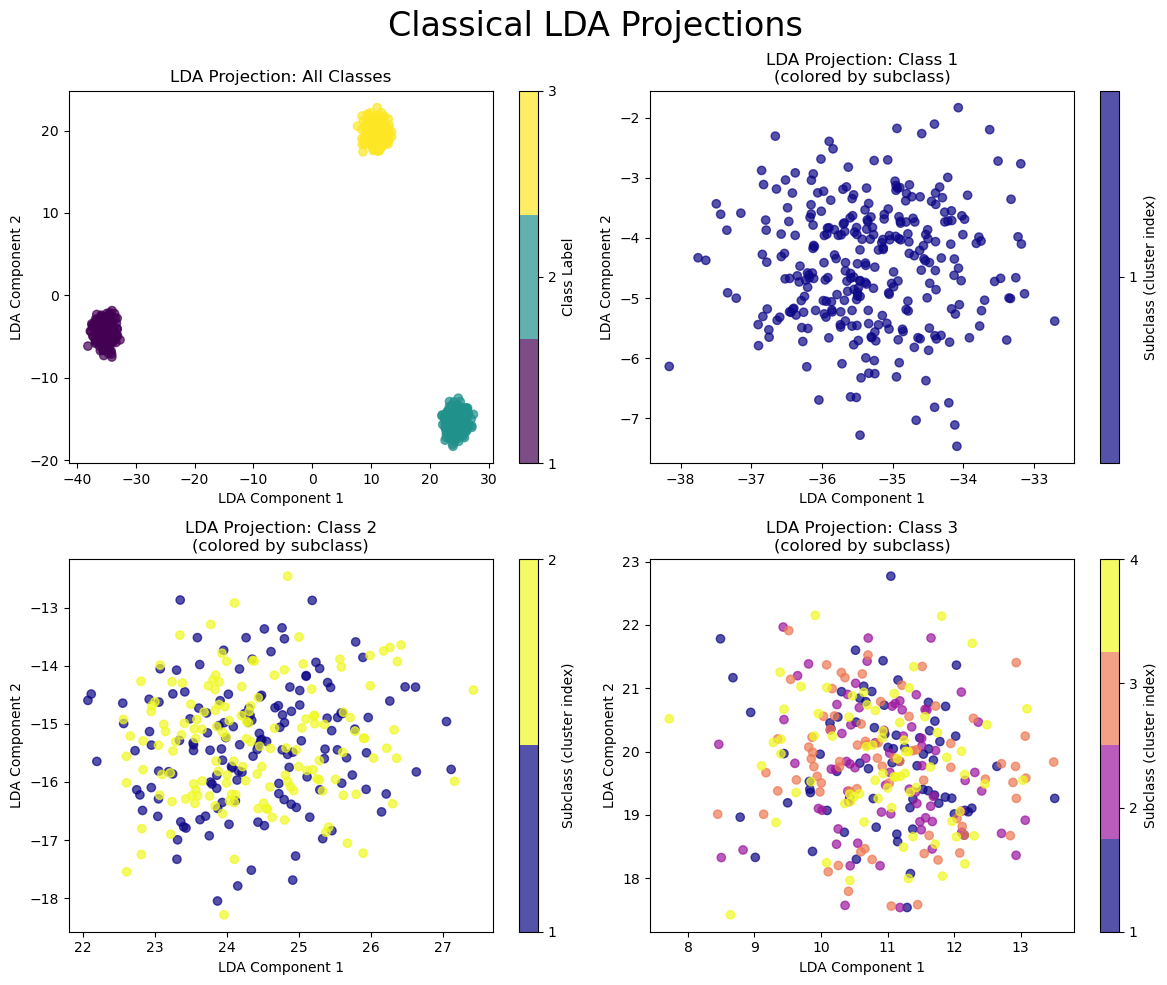

In [266]:
lda = LinearDiscriminantAnalysis(n_components=2)
data_points_2d = lda.fit_transform(data_points, labels_class)

# Create a 2x2 subplot grid.
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.tight_layout(pad=4.0)

ax = axs[0, 0]
unique_classes = np.unique(labels_class)
num_classes = len(unique_classes)

discrete_cmap_all = plt.cm.get_cmap('viridis', num_classes)

scatter_all = ax.scatter(data_points_2d[:, 0], data_points_2d[:, 1],
                         c=labels_class, cmap=discrete_cmap_all, alpha=0.7)
ax.set_xlabel("LDA Component 1")
ax.set_ylabel("LDA Component 2")
ax.set_title("LDA Projection: All Classes")

cbar_all = fig.colorbar(scatter_all, ax=ax, ticks=unique_classes)
cbar_all.set_label('Class Label')
cbar_all.ax.set_yticklabels(unique_classes)

positions = [(0, 1), (1, 0), (1, 1)]
for pos, class_label in zip(positions, unique_classes):
    i, j = pos
    ax = axs[i, j]
    
    indices = np.where(labels_class == class_label)[0]
    data_class = data_points_2d[indices, :]
    
    subclass_vals = np.array([lbl[1] for lbl in labels_cluster[indices]])
    unique_subclasses = np.unique(subclass_vals)
    num_subclasses = len(unique_subclasses)
    discrete_cmap_sub = plt.cm.get_cmap('plasma', num_subclasses)
    
    scatter_cls = ax.scatter(data_class[:, 0], data_class[:, 1],
                             c=subclass_vals, cmap=discrete_cmap_sub, alpha=0.7)
    ax.set_xlabel("LDA Component 1")
    ax.set_ylabel("LDA Component 2")
    ax.set_title(f"LDA Projection: Class {class_label}\n(colored by subclass)")
    
    cbar_sub = fig.colorbar(scatter_cls, ax=ax, ticks=unique_subclasses)
    cbar_sub.set_label('Subclass (cluster index)')
    cbar_sub.ax.set_yticklabels(unique_subclasses)

plt.suptitle("Classical LDA Projections", fontsize=24)
plt.tight_layout()
plt.show()

# Naive Adjustment

/var/folders/zd/c5dfjvdd3850xf529yxpdznw0000gq/T/ipykernel_37767/1415554703.py:117: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  discrete_cmap_all = plt.cm.get_cmap('viridis', num_classes)
/var/folders/zd/c5dfjvdd3850xf529yxpdznw0000gq/T/ipykernel_37767/1415554703.py:140: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  discrete_cmap_sub = plt.cm.get_cmap('plasma', len(unique_subs))
/var/folders/zd/c5dfjvdd3850xf529yxpdznw0000gq/T/ipykernel_37767/1415554703.py:140: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.g

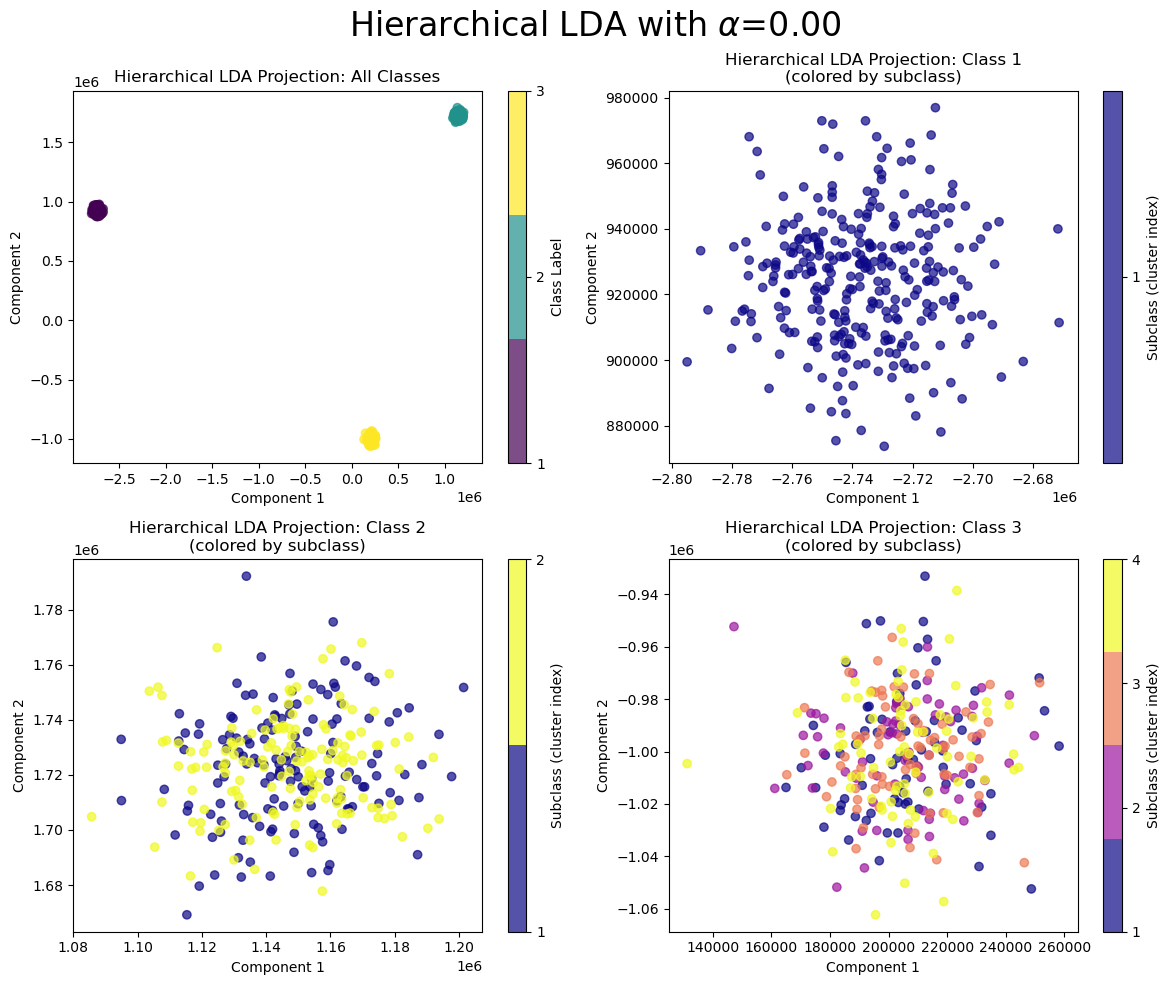

/var/folders/zd/c5dfjvdd3850xf529yxpdznw0000gq/T/ipykernel_37767/1415554703.py:117: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  discrete_cmap_all = plt.cm.get_cmap('viridis', num_classes)
/var/folders/zd/c5dfjvdd3850xf529yxpdznw0000gq/T/ipykernel_37767/1415554703.py:140: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  discrete_cmap_sub = plt.cm.get_cmap('plasma', len(unique_subs))
/var/folders/zd/c5dfjvdd3850xf529yxpdznw0000gq/T/ipykernel_37767/1415554703.py:140: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.g

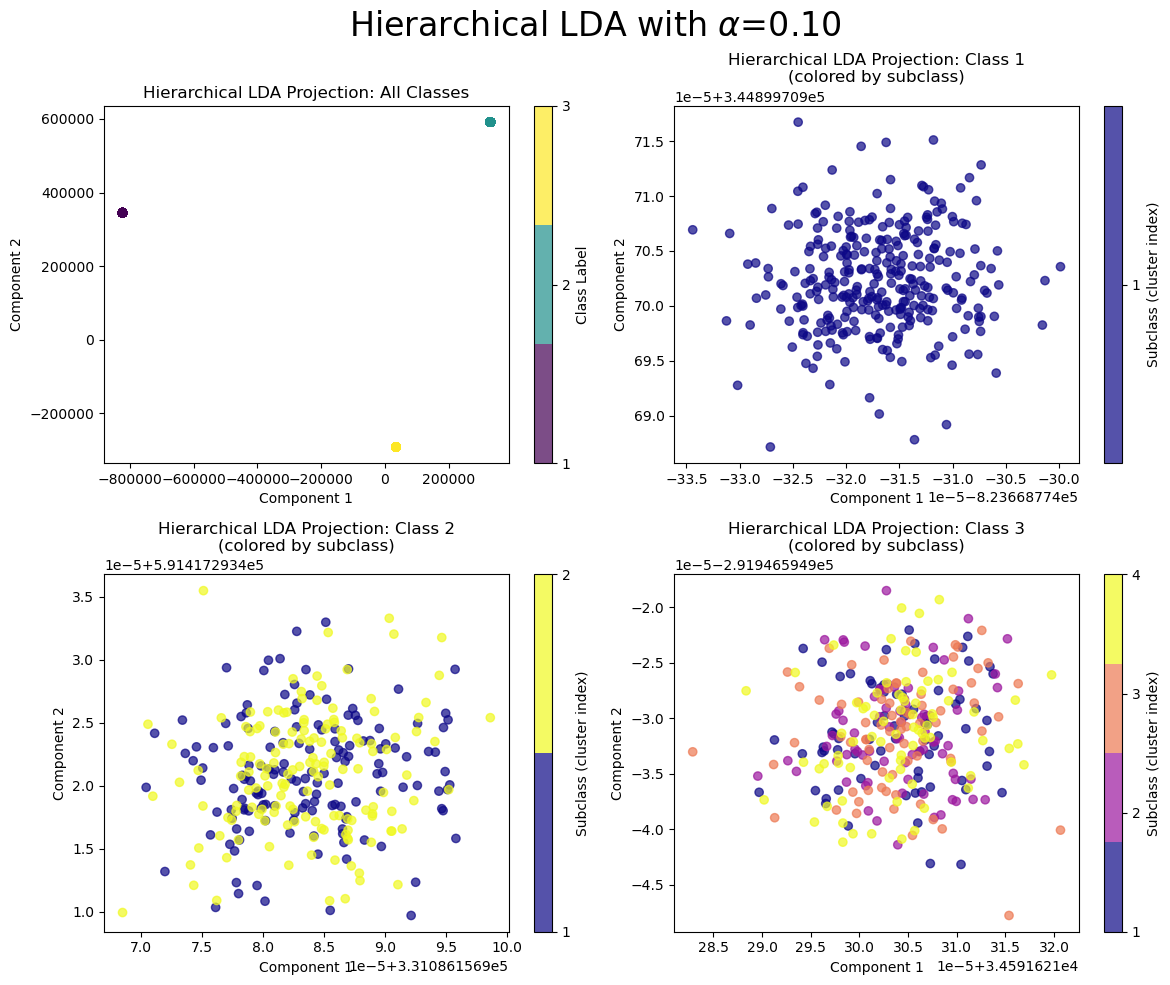

/var/folders/zd/c5dfjvdd3850xf529yxpdznw0000gq/T/ipykernel_37767/1415554703.py:117: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  discrete_cmap_all = plt.cm.get_cmap('viridis', num_classes)
/var/folders/zd/c5dfjvdd3850xf529yxpdznw0000gq/T/ipykernel_37767/1415554703.py:140: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  discrete_cmap_sub = plt.cm.get_cmap('plasma', len(unique_subs))
/var/folders/zd/c5dfjvdd3850xf529yxpdznw0000gq/T/ipykernel_37767/1415554703.py:140: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.g

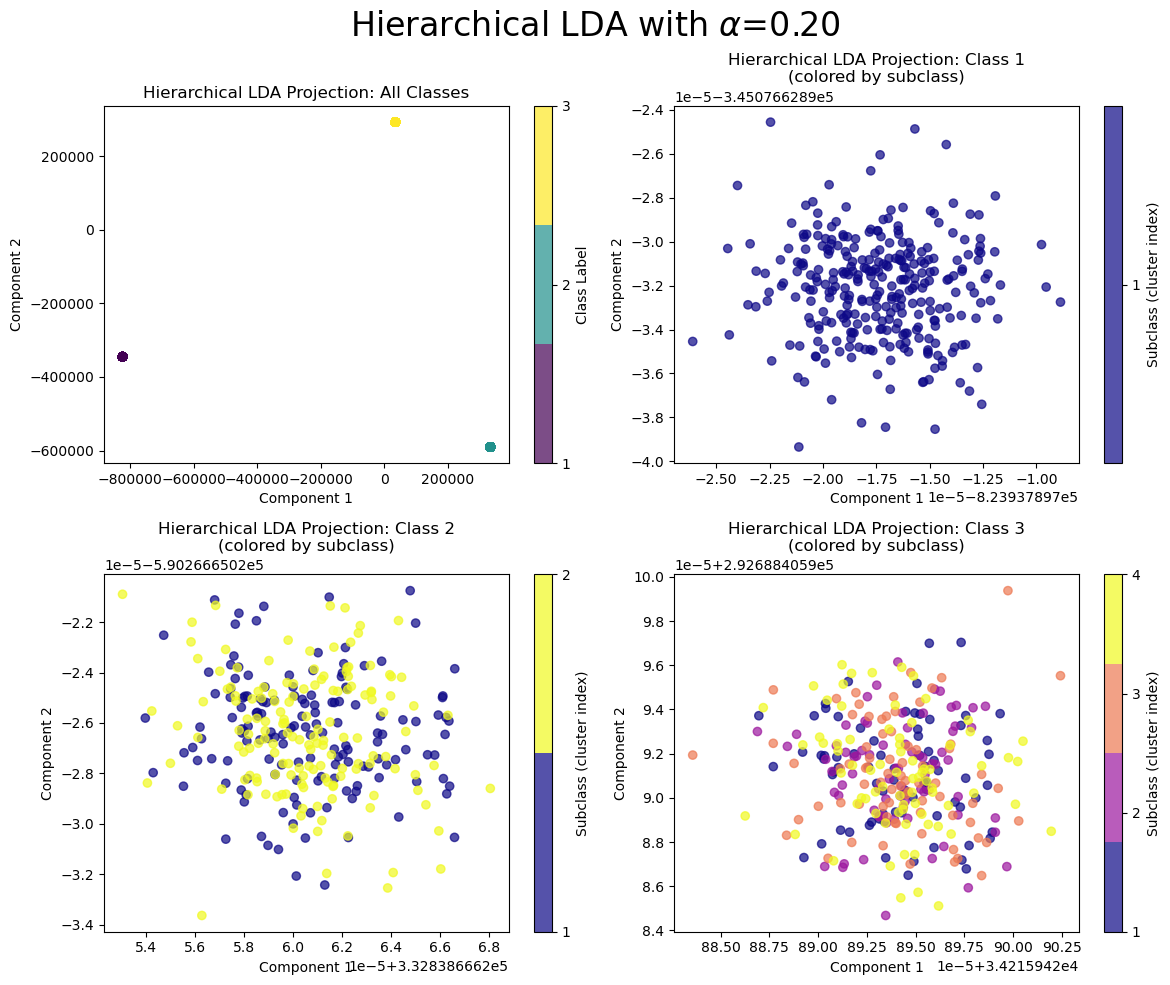

/var/folders/zd/c5dfjvdd3850xf529yxpdznw0000gq/T/ipykernel_37767/1415554703.py:117: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  discrete_cmap_all = plt.cm.get_cmap('viridis', num_classes)
/var/folders/zd/c5dfjvdd3850xf529yxpdznw0000gq/T/ipykernel_37767/1415554703.py:140: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  discrete_cmap_sub = plt.cm.get_cmap('plasma', len(unique_subs))
/var/folders/zd/c5dfjvdd3850xf529yxpdznw0000gq/T/ipykernel_37767/1415554703.py:140: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.g

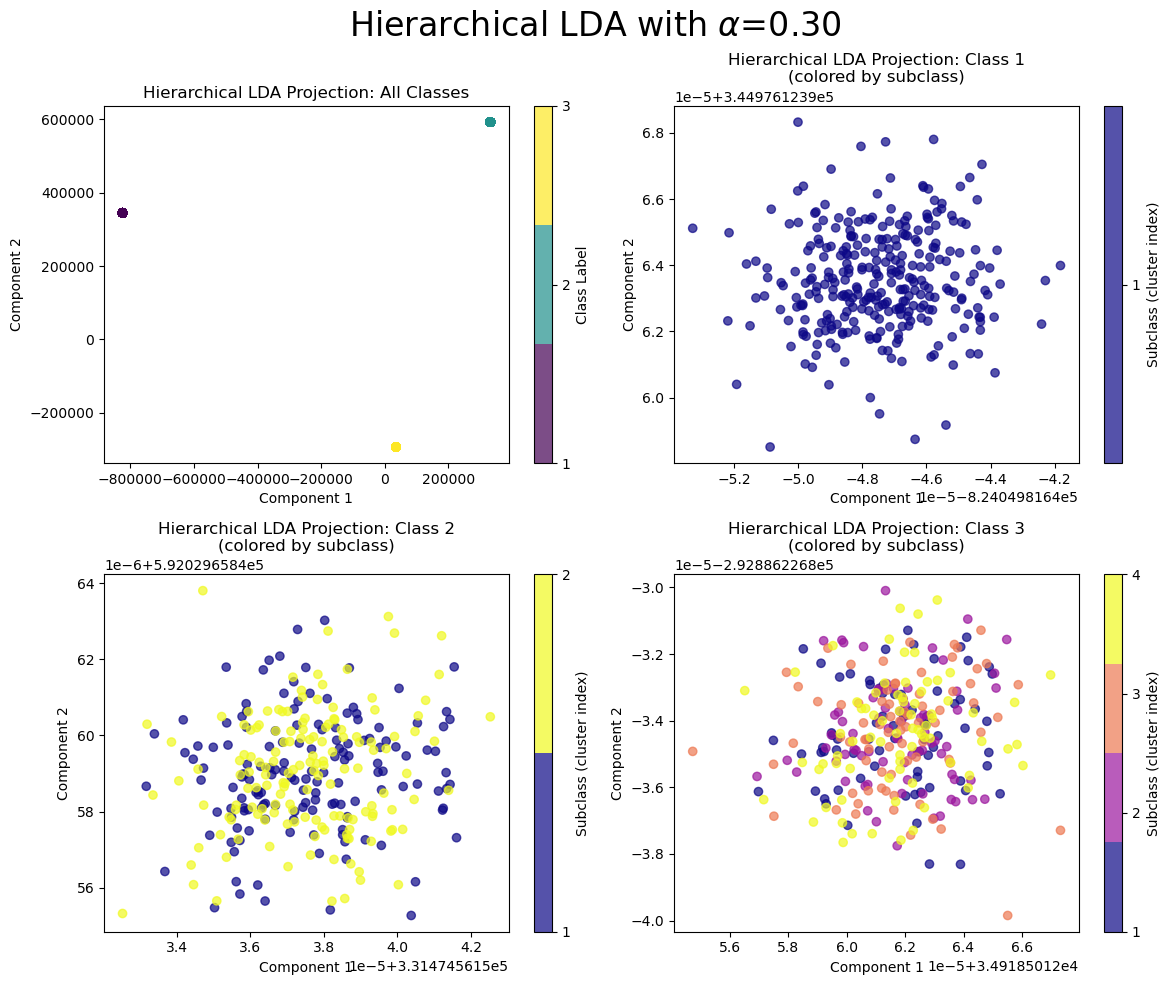

/var/folders/zd/c5dfjvdd3850xf529yxpdznw0000gq/T/ipykernel_37767/1415554703.py:117: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  discrete_cmap_all = plt.cm.get_cmap('viridis', num_classes)
/var/folders/zd/c5dfjvdd3850xf529yxpdznw0000gq/T/ipykernel_37767/1415554703.py:140: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  discrete_cmap_sub = plt.cm.get_cmap('plasma', len(unique_subs))
/var/folders/zd/c5dfjvdd3850xf529yxpdznw0000gq/T/ipykernel_37767/1415554703.py:140: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.g

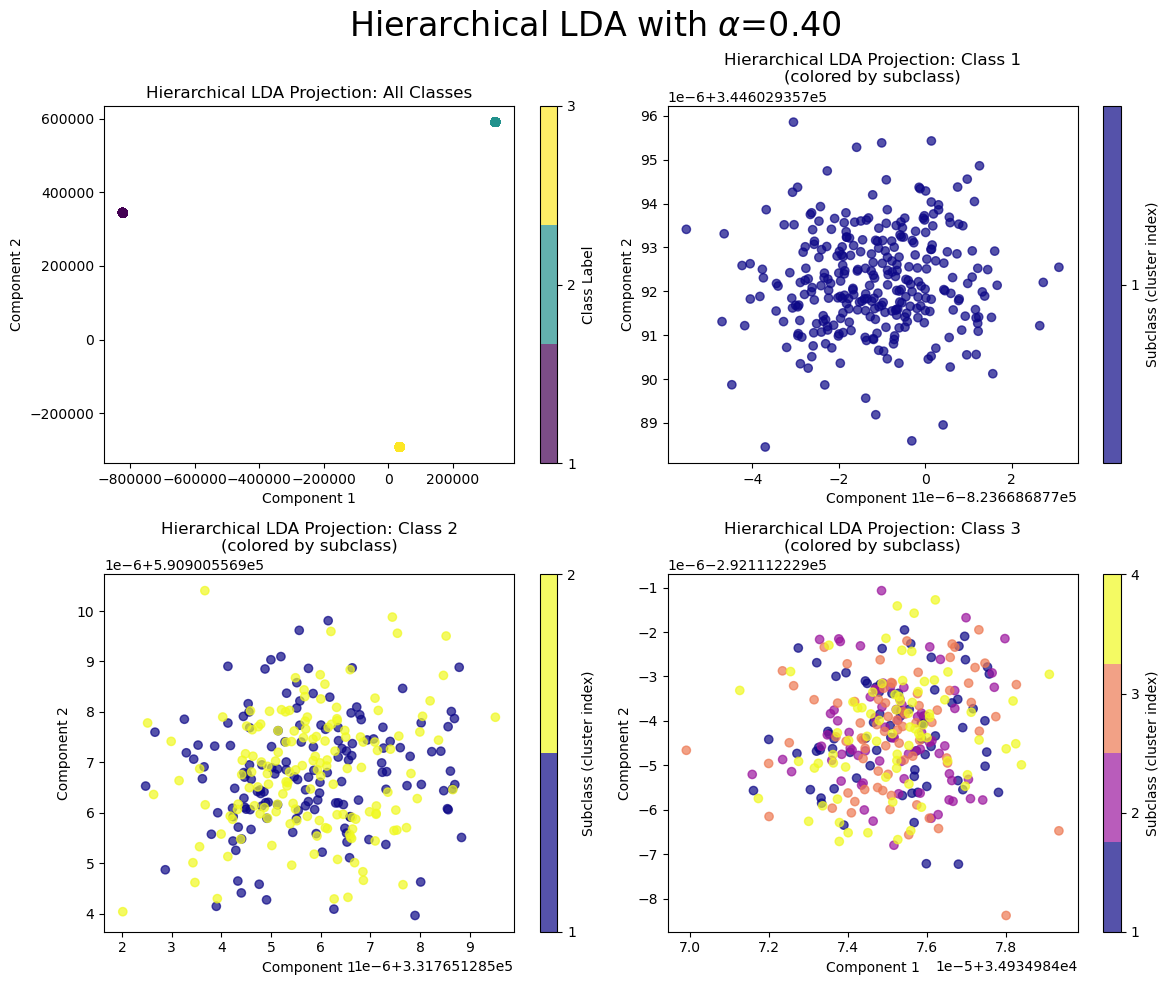

/var/folders/zd/c5dfjvdd3850xf529yxpdznw0000gq/T/ipykernel_37767/1415554703.py:117: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  discrete_cmap_all = plt.cm.get_cmap('viridis', num_classes)
/var/folders/zd/c5dfjvdd3850xf529yxpdznw0000gq/T/ipykernel_37767/1415554703.py:140: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  discrete_cmap_sub = plt.cm.get_cmap('plasma', len(unique_subs))
/var/folders/zd/c5dfjvdd3850xf529yxpdznw0000gq/T/ipykernel_37767/1415554703.py:140: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.g

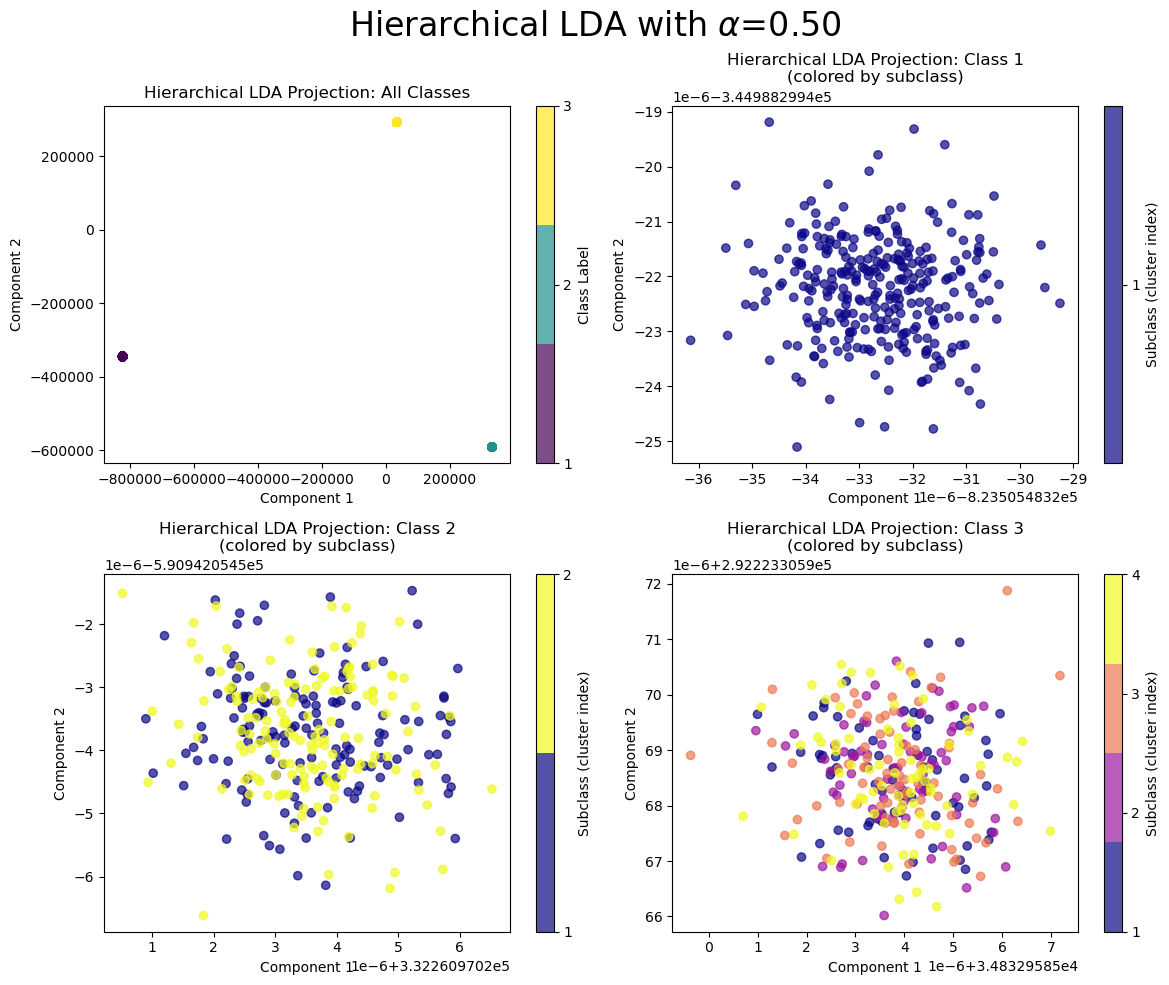

/var/folders/zd/c5dfjvdd3850xf529yxpdznw0000gq/T/ipykernel_37767/1415554703.py:117: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  discrete_cmap_all = plt.cm.get_cmap('viridis', num_classes)
/var/folders/zd/c5dfjvdd3850xf529yxpdznw0000gq/T/ipykernel_37767/1415554703.py:140: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  discrete_cmap_sub = plt.cm.get_cmap('plasma', len(unique_subs))
/var/folders/zd/c5dfjvdd3850xf529yxpdznw0000gq/T/ipykernel_37767/1415554703.py:140: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.g

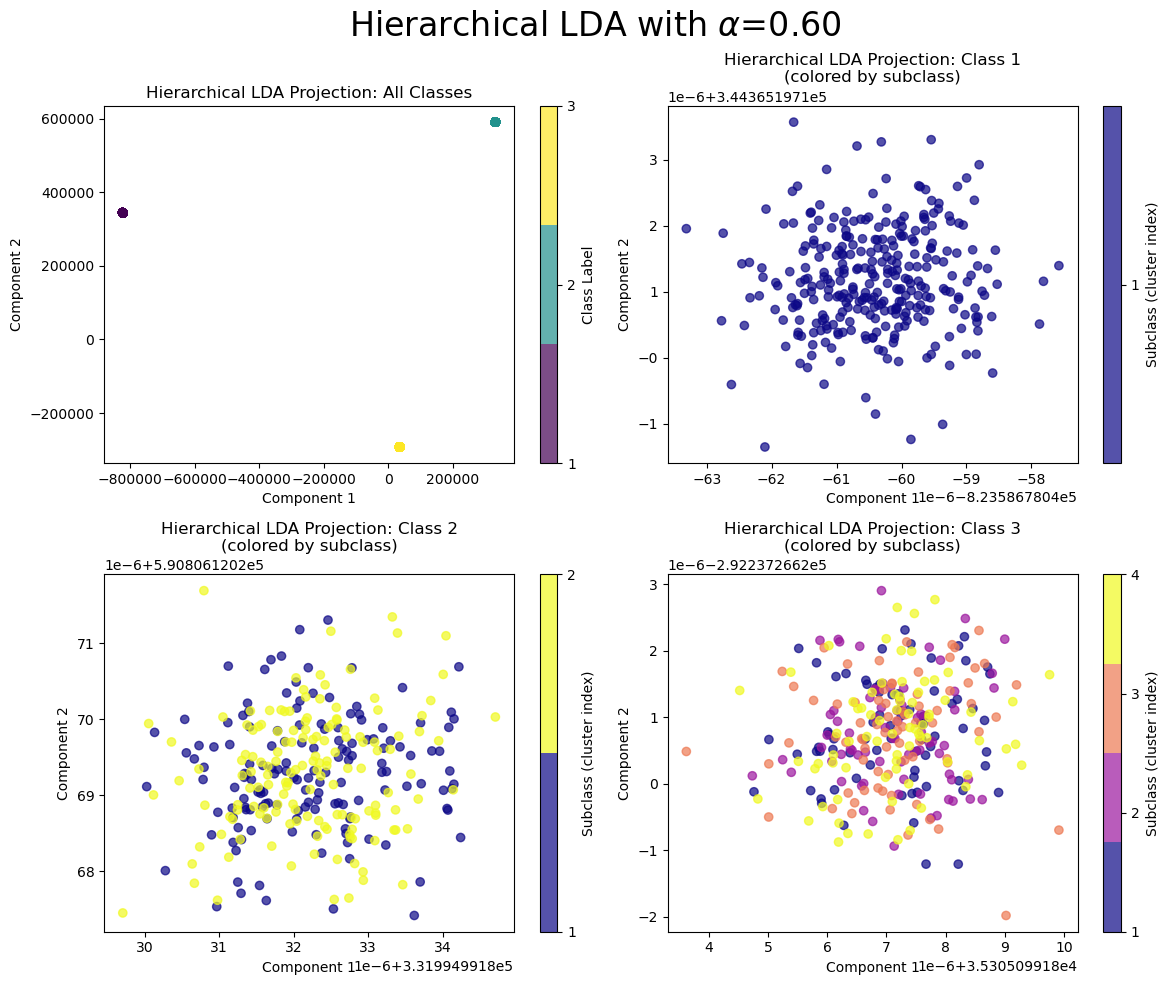

/var/folders/zd/c5dfjvdd3850xf529yxpdznw0000gq/T/ipykernel_37767/1415554703.py:117: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  discrete_cmap_all = plt.cm.get_cmap('viridis', num_classes)
/var/folders/zd/c5dfjvdd3850xf529yxpdznw0000gq/T/ipykernel_37767/1415554703.py:140: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  discrete_cmap_sub = plt.cm.get_cmap('plasma', len(unique_subs))
/var/folders/zd/c5dfjvdd3850xf529yxpdznw0000gq/T/ipykernel_37767/1415554703.py:140: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.g

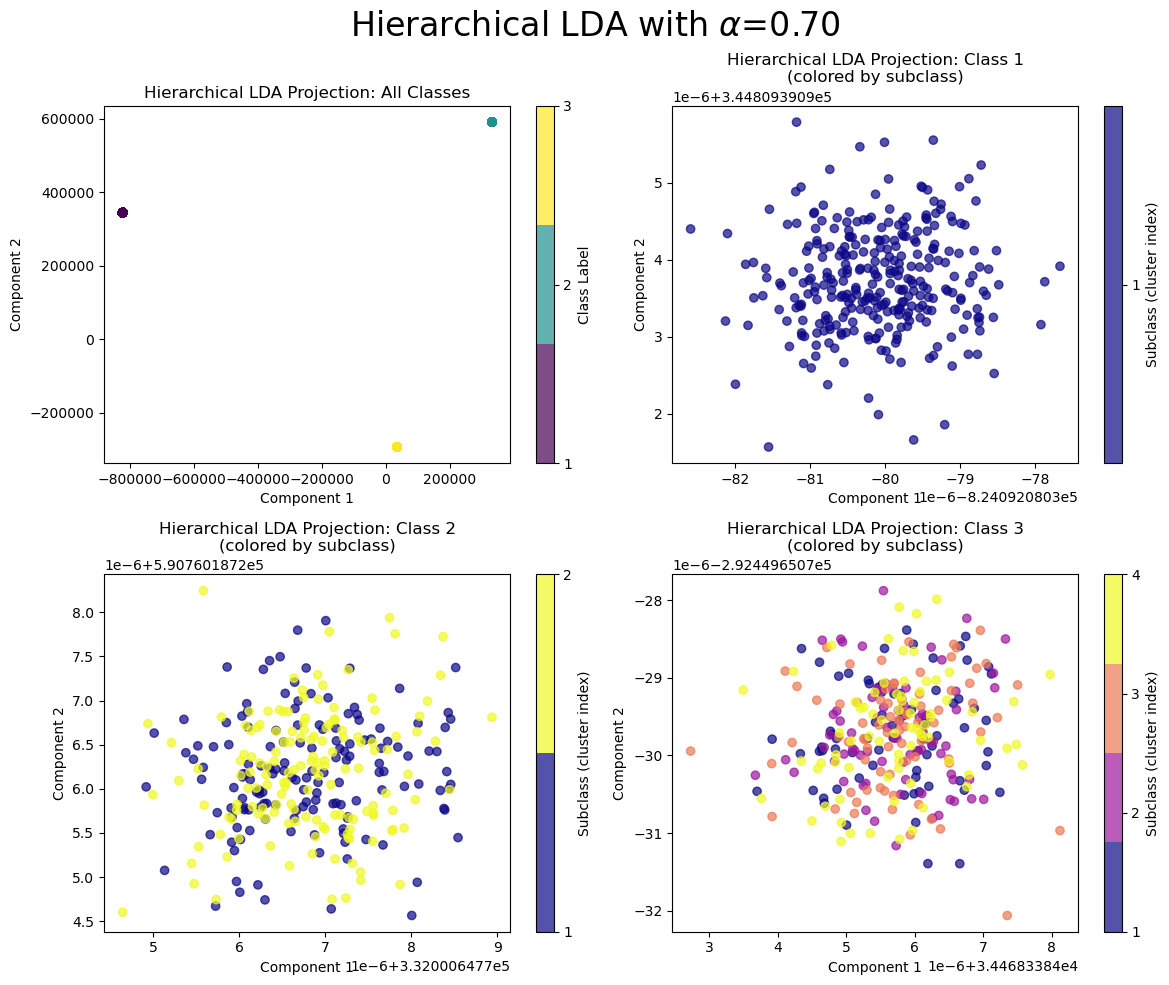

/var/folders/zd/c5dfjvdd3850xf529yxpdznw0000gq/T/ipykernel_37767/1415554703.py:117: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  discrete_cmap_all = plt.cm.get_cmap('viridis', num_classes)
/var/folders/zd/c5dfjvdd3850xf529yxpdznw0000gq/T/ipykernel_37767/1415554703.py:140: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  discrete_cmap_sub = plt.cm.get_cmap('plasma', len(unique_subs))
/var/folders/zd/c5dfjvdd3850xf529yxpdznw0000gq/T/ipykernel_37767/1415554703.py:140: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.g

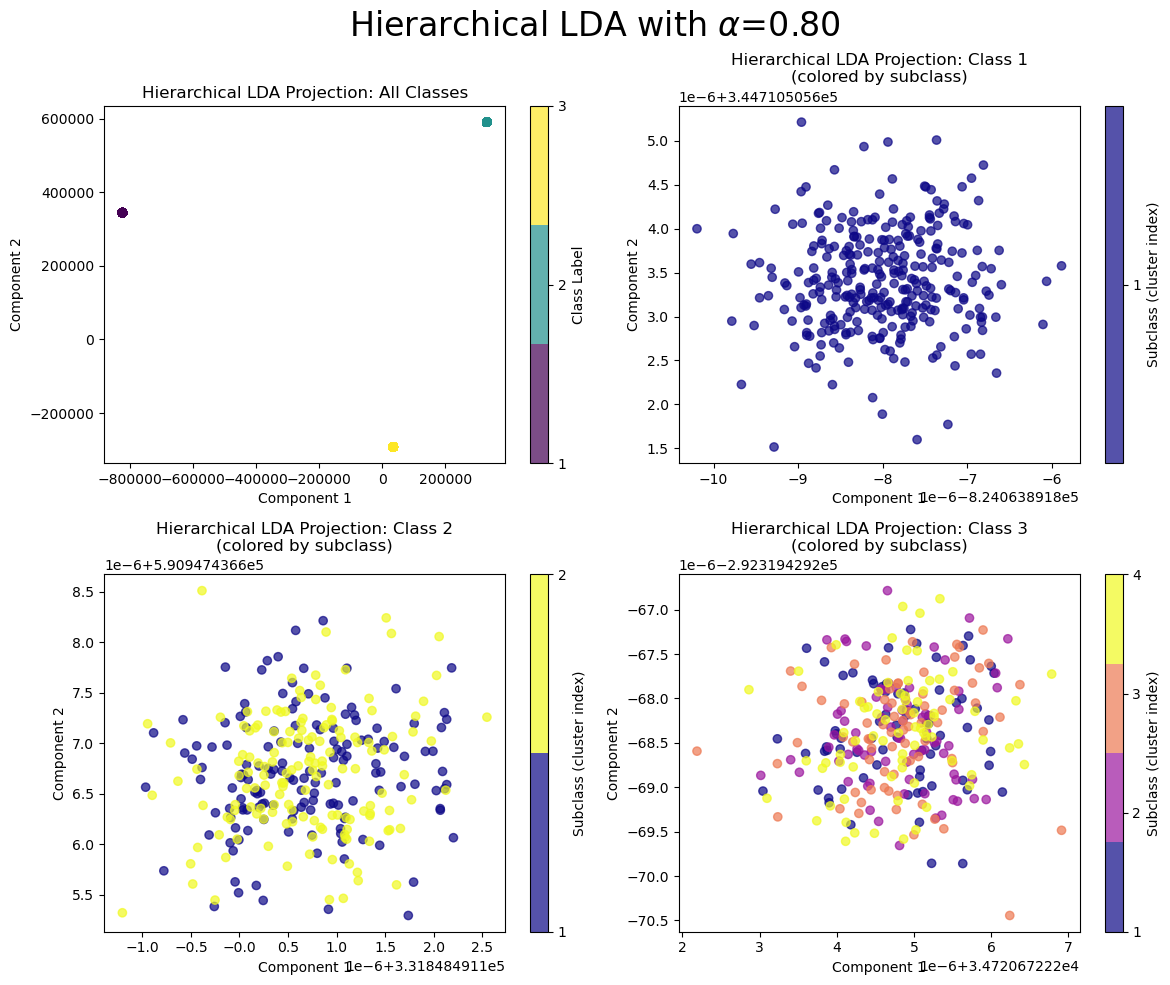

/var/folders/zd/c5dfjvdd3850xf529yxpdznw0000gq/T/ipykernel_37767/1415554703.py:117: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  discrete_cmap_all = plt.cm.get_cmap('viridis', num_classes)
/var/folders/zd/c5dfjvdd3850xf529yxpdznw0000gq/T/ipykernel_37767/1415554703.py:140: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  discrete_cmap_sub = plt.cm.get_cmap('plasma', len(unique_subs))
/var/folders/zd/c5dfjvdd3850xf529yxpdznw0000gq/T/ipykernel_37767/1415554703.py:140: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.g

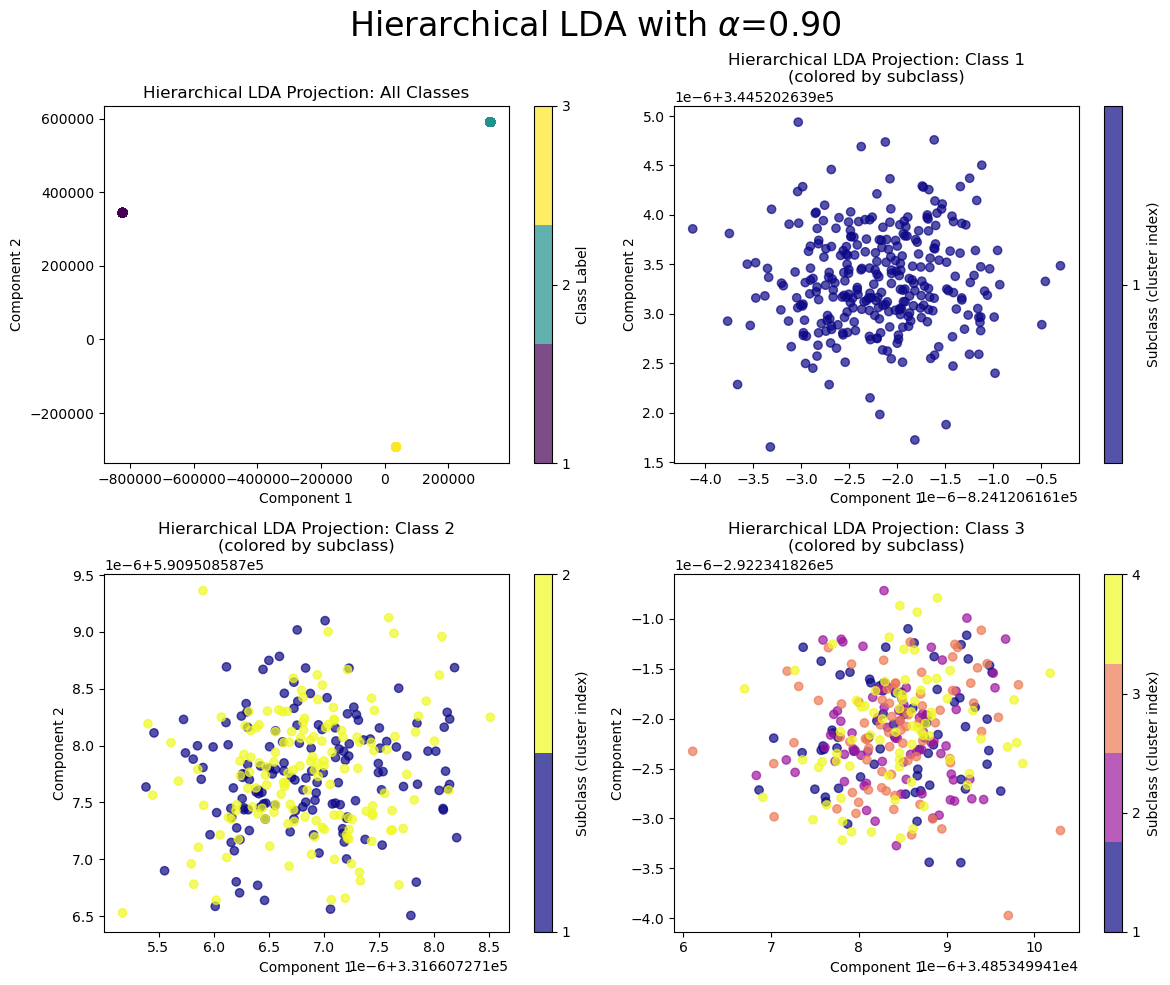

/var/folders/zd/c5dfjvdd3850xf529yxpdznw0000gq/T/ipykernel_37767/1415554703.py:117: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  discrete_cmap_all = plt.cm.get_cmap('viridis', num_classes)
/var/folders/zd/c5dfjvdd3850xf529yxpdznw0000gq/T/ipykernel_37767/1415554703.py:140: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  discrete_cmap_sub = plt.cm.get_cmap('plasma', len(unique_subs))
/var/folders/zd/c5dfjvdd3850xf529yxpdznw0000gq/T/ipykernel_37767/1415554703.py:140: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.g

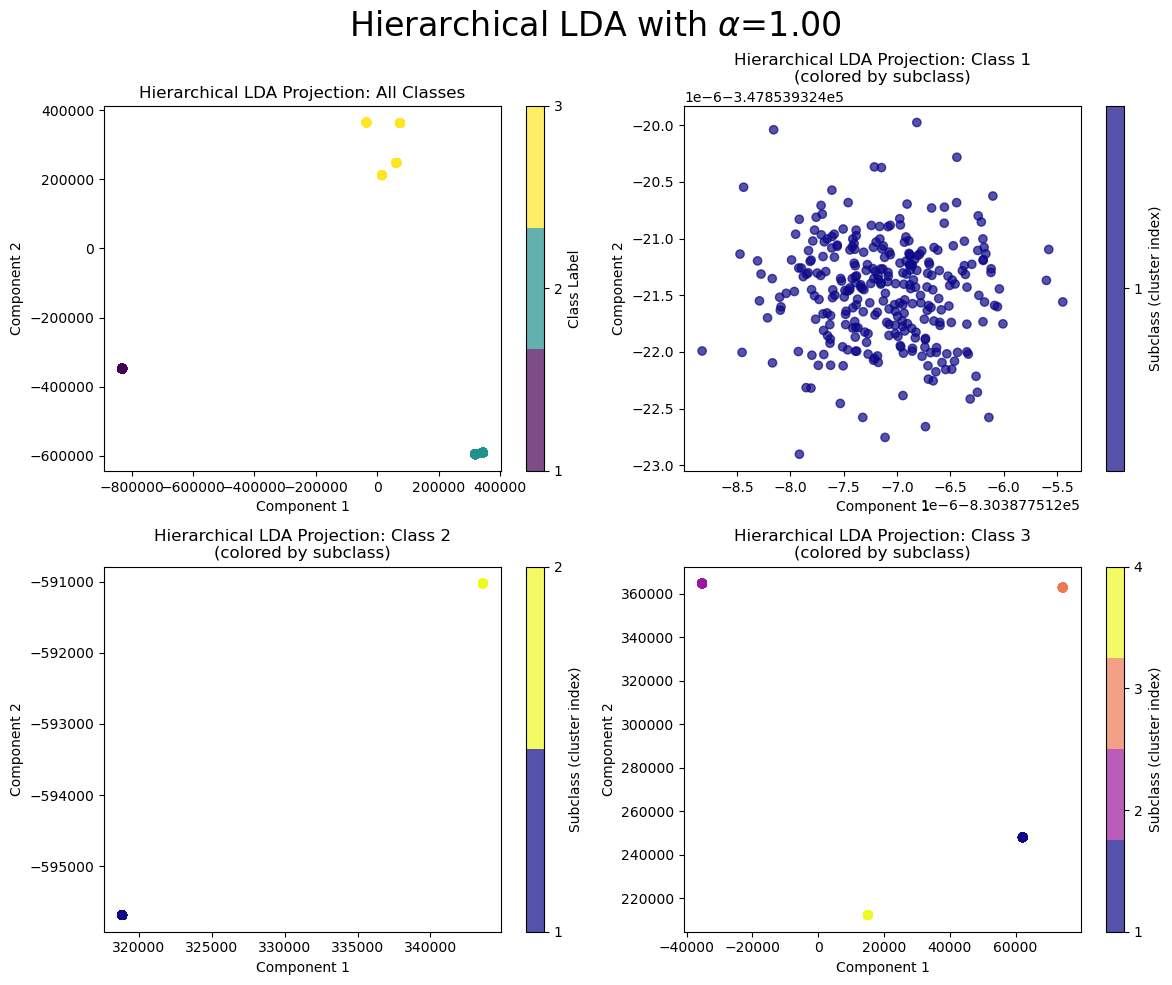

In [267]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh  # For generalized eigenvalue problem

clusters_per_class = {
    1: [300],
    2: [150, 150],
    3: [75, 75, 75, 75]
}

dims = 1000

class_std = 2
subclass_std = 100
cluster_std = 20

# Fixed base class means — orthogonal directions
class_means = {
    1: np.pad([100], (0, dims - 1)),
    2: np.pad([0, 100], (0, dims - 2)),
    3: np.pad([0, 0, 100], (0, dims - 3))
}

data_points = []    
labels_class = []    
labels_cluster = []

for class_label, cluster_sizes in clusters_per_class.items():
    base_mean = class_means[class_label]
    for cluster_index, n_points in enumerate(cluster_sizes, start=1):
        subclass_mean = base_mean + np.random.randn(dims) * subclass_std
        points = subclass_mean + np.random.randn(n_points, dims) * cluster_std
        data_points.append(points)
        labels_class.extend([class_label] * n_points)
        labels_cluster.extend([(class_label, cluster_index)] * n_points)

data_points = np.vstack(data_points)
labels_class = np.array(labels_class)
labels_cluster = np.array(labels_cluster)


# ----------------------
# Compute Scatter Matrices
# ----------------------
N_total = data_points.shape[0]
overall_mean = np.mean(data_points, axis=0)

# Unique classes
unique_classes = np.unique(labels_class)
dims = data_points.shape[1]

# Initialize matrices
S_B = np.zeros((dims, dims))  
S_WS = np.zeros((dims, dims)) 
S_BS = np.zeros((dims, dims)) 

# Compute S_B (between-class scatter)
for c in unique_classes:
    idx = np.where(labels_class == c)[0]
    X_c = data_points[idx, :]
    N_c = X_c.shape[0]
    mu_c = np.mean(X_c, axis=0)
    S_B += N_c * np.outer(mu_c - overall_mean, mu_c - overall_mean)

# Compute S_WS and S_BS using subclass structure
for c in unique_classes:
    # Indices for class c
    idx_class = np.where(labels_class == c)[0]
    X_c = data_points[idx_class, :]
    mu_c = np.mean(X_c, axis=0)
    
    # Get unique subclass indices for class c:
    # labels_cluster for class c are tuples (c, subclass_index)
    subclass_ids = np.unique([lbl[1] for lbl in labels_cluster[idx_class]])
    
    for sub in subclass_ids:
        # Select indices corresponding to subclass (c, sub)
        idx_sub = np.where(np.all(labels_cluster == np.array((c, sub)), axis=1))[0]
        X_cs = data_points[idx_sub, :]
        N_cs = X_cs.shape[0]
        mu_cs = np.mean(X_cs, axis=0)
        # Within-subclass scatter for subclass (c, sub):
        diff = X_cs - mu_cs
        S_WS += diff.T @ diff
        # Between-subclass scatter: how the subclass mean deviates from the class mean
        S_BS += N_cs * np.outer(mu_cs - mu_c, mu_cs - mu_c)

# Choose alpha in [0, 1] for combining the two scatter matrices
for alpha in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
    S_W_mod = alpha * S_WS + (1 - alpha) * S_BS

    # Regularize S_W_mod to avoid singularity (if needed)
    reg = 1e-6
    S_W_mod += reg * np.eye(dims)

    # ----------------------
    # Solve the Generalized Eigenvalue Problem
    # ----------------------
    # We solve: S_B * w = lambda * S_W_mod * w
    # This is equivalent to finding the projection matrix W that maximizes:
    #       J(W) = (W^T S_B W) / (W^T S_W_mod W)
    eigvals, eigvecs = eigh(S_B, S_W_mod)

    # eigh returns eigenvalues in ascending order;
    # select the eigenvectors corresponding to the top 2 eigenvalues.
    top_indices = np.argsort(eigvals)[::-1][:2]
    W = eigvecs[:, top_indices]  # Projection matrix (dims x 2)


    # Project the data
    data_points_2d = data_points @ W

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    fig.tight_layout(pad=4.0)

    num_classes = len(unique_classes)
    discrete_cmap_all = plt.cm.get_cmap('viridis', num_classes)

    ax = axs[0, 0]
    scatter_all = ax.scatter(data_points_2d[:, 0], data_points_2d[:, 1],
                            c=labels_class, cmap=discrete_cmap_all, alpha=0.7)
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.set_title("Hierarchical LDA Projection: All Classes")
    cbar_all = fig.colorbar(scatter_all, ax=ax, ticks=unique_classes)
    cbar_all.set_label('Class Label')
    cbar_all.ax.set_yticklabels(unique_classes)

    # Positions for per-class plots (3 classes → 3 subplots)
    positions = [(0, 1), (1, 0), (1, 1)]

    for pos, c in zip(positions, unique_classes):
        i, j = pos
        ax = axs[i, j]
        idx = np.where(labels_class == c)[0]
        X_c_2d = data_points_2d[idx, :]
        # For subclass coloring, extract subclass index (second element of tuple)
        subclass_vals = np.array([lbl[1] for lbl in labels_cluster[idx]])
        unique_subs = np.unique(subclass_vals)
        discrete_cmap_sub = plt.cm.get_cmap('plasma', len(unique_subs))
        
        scatter_sub = ax.scatter(X_c_2d[:, 0], X_c_2d[:, 1],
                                c=subclass_vals, cmap=discrete_cmap_sub, alpha=0.7)
        ax.set_xlabel("Component 1")
        ax.set_ylabel("Component 2")
        ax.set_title(f"Hierarchical LDA Projection: Class {c}\n(colored by subclass)")
        cbar_sub = fig.colorbar(scatter_sub, ax=ax, ticks=unique_subs)
        cbar_sub.set_label("Subclass (cluster index)")
        cbar_sub.ax.set_yticklabels(unique_subs)
    plt.suptitle(f"Hierarchical LDA with $\\alpha$={alpha:.2f}", fontsize=24)
    plt.tight_layout()
    plt.show()


# Regularization Parameters

## Redefined $S_W$

Hierarchical LDA objective value: 23373.609605992708


/var/folders/zd/c5dfjvdd3850xf529yxpdznw0000gq/T/ipykernel_37767/370092565.py:177: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  discrete_cmap_all = plt.cm.get_cmap('viridis', num_classes)
/var/folders/zd/c5dfjvdd3850xf529yxpdznw0000gq/T/ipykernel_37767/370092565.py:199: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  discrete_cmap_sub = plt.cm.get_cmap('plasma', len(unique_subclasses))
/var/folders/zd/c5dfjvdd3850xf529yxpdznw0000gq/T/ipykernel_37767/370092565.py:199: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormap

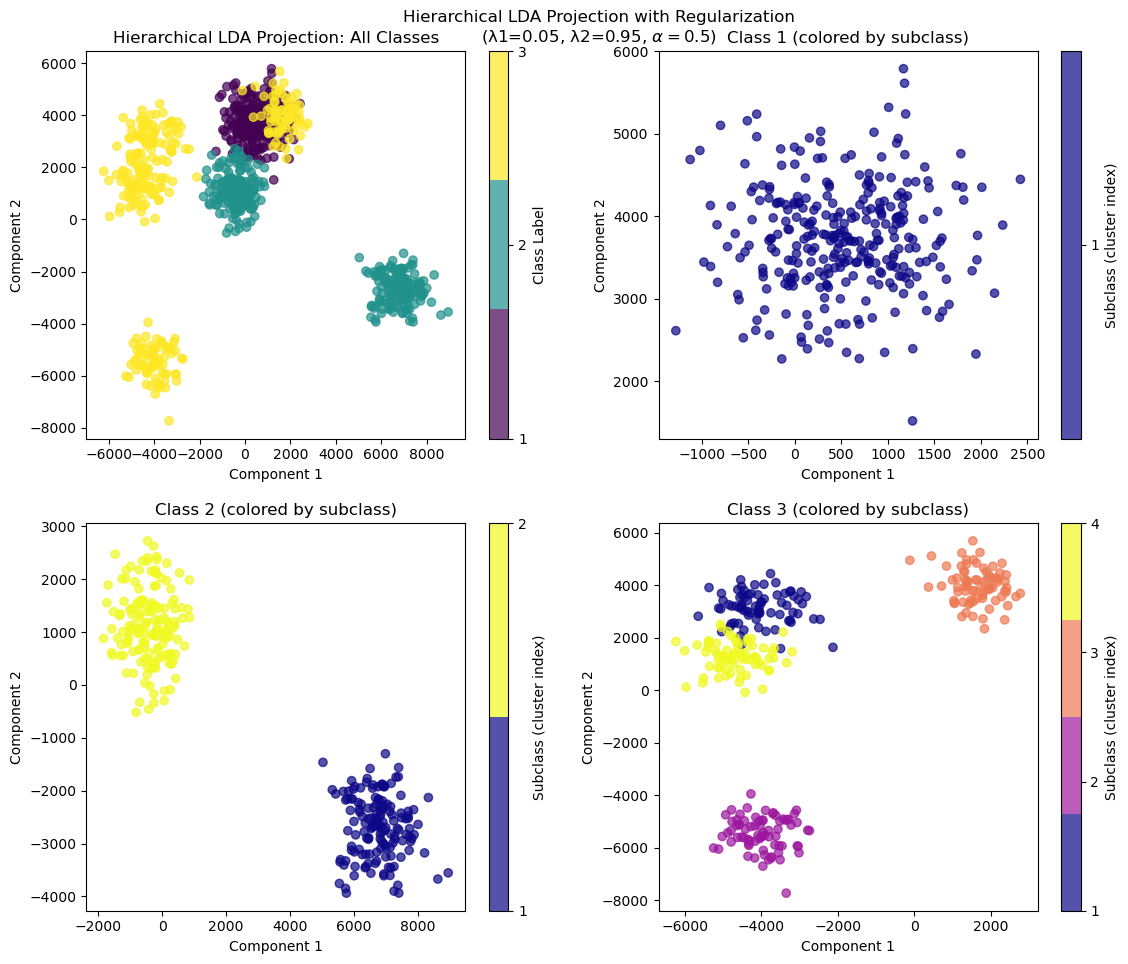

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh  # For solving the generalized eigenvalue problem

# ----------------------
# Data Generation (Hierarchical Data)
# ----------------------
# We assume:
#   - Parent classes: 1, 2, 3
#   - Class 1 has 1 subclass; Class 2 has 2 subclasses; Class 3 has 4 subclasses.
clusters_per_class = {
    1: [300],
    2: [150, 150],
    3: [75, 75, 75, 75]
}

dims = 3

# Spread parameters:
class_std = 2
subclass_std = 100
cluster_std = 20

data_points = []    
labels_class = []     # Overall parent (class) labels
labels_cluster = []   # Subclass labels (tuples: (class_label, subclass_index))

class_means = {}      # To store base means (for reference)

for class_label, cluster_sizes in clusters_per_class.items():
    # Generate a base mean for the current parent class.
    base_mean = np.random.randn(dims) * class_std
    class_means[class_label] = base_mean

    for cluster_index, n_points in enumerate(cluster_sizes, start=1):
        # Generate a subclass mean by adding jitter to the base mean.
        subclass_mean = base_mean + np.random.randn(dims) * subclass_std
        # Generate data points around this subclass mean.
        points = subclass_mean + np.random.randn(n_points, dims) * cluster_std
        
        data_points.append(points)
        labels_class.extend([class_label] * n_points)
        labels_cluster.extend([(class_label, cluster_index)] * n_points)

data_points = np.vstack(data_points)
labels_class = np.array(labels_class)
labels_cluster = np.array(labels_cluster)  # Array of tuples

# ----------------------
# Compute Scatter Matrices and Hierarchical Means
# ----------------------
N_total = data_points.shape[0]
overall_mean = np.mean(data_points, axis=0)
unique_classes = np.unique(labels_class)
d = dims

# Standard Between-Class Scatter (S_B)
S_B = np.zeros((d, d))
for c in unique_classes:
    idx = np.where(labels_class == c)[0]
    X_c = data_points[idx, :]
    N_c = X_c.shape[0]
    mu_c = np.mean(X_c, axis=0)
    S_B += N_c * np.outer(mu_c - overall_mean, mu_c - overall_mean)

# Hierarchical scatter matrices:
S_WS = np.zeros((d, d))   # Within-subclass scatter
S_BS = np.zeros((d, d))   # Between-subclass scatter within each parent class

# Also, compute parent class means and subclass means dictionaries.
parent_means = {}       # parent_means[c] = mean vector for class c.
subclass_means = {}     # subclass_means[c] = list of subclass means for class c.

for c in unique_classes:
    idx_class = np.where(labels_class == c)[0]
    X_c = data_points[idx_class, :]
    mu_c = np.mean(X_c, axis=0)
    parent_means[c] = mu_c

    # Get unique subclass indices for class c.
    class_subs = np.array([lbl[1] for lbl in labels_cluster[idx_class]])
    unique_subs = np.unique(class_subs)
    subclass_means[c] = []
    for sub in unique_subs:
        # Find indices corresponding to subclass (c, sub)
        idx_sub = np.where(np.array([ (lbl[0] == c and lbl[1] == sub) for lbl in labels_cluster ]))[0]
        X_cs = data_points[idx_sub, :]
        N_cs = X_cs.shape[0]
        mu_cs = np.mean(X_cs, axis=0)
        subclass_means[c].append(mu_cs)
        # Within-subclass scatter: sum of (x - mu_cs)(x - mu_cs)^T over subclass points.
        diff = X_cs - mu_cs
        S_WS += diff.T @ diff
        # Between-subclass scatter: deviation of subclass mean from parent mean.
        S_BS += N_cs * np.outer(mu_cs - mu_c, mu_cs - mu_c)

# Blend the within-class scatter: S_W = α S_WS + (1 - α) S_BS.
alpha = 0.5
S_W = alpha * S_WS + (1 - alpha) * S_BS

# Regularize S_W to avoid singularity.
reg = 1e-8
S_W += reg * np.eye(d)

# ----------------------
# Define the Hierarchical LDA Objective with Regularization Terms
# ----------------------
def hierarchical_lda_objective(W, S_B, S_W, subclass_means, parent_means, 
                               lambda1, lambda2, eps=1e-8):
    """
    Computes the modified LDA objective with two regularization terms.
    
    W: Projection matrix of shape (d, r) (e.g. (1000, 2))
    S_B: Between-class scatter matrix.
    S_W: Modified within-class scatter matrix (hierarchical).
    subclass_means: dict mapping class c to list of subclass mean vectors.
    parent_means: dict mapping class c to parent class mean.
    lambda1: Regularization weight for R1.
    lambda2: Regularization weight for R2.
    eps: Small constant to prevent division by zero.
    
    Returns the hierarchical LDA objective value:
        J*(W) = (tr(W^T S_B W))/(tr(W^T S_W W)) + lambda1 * R1(W) + lambda2 * R2(W)
    """
    # Classical LDA objective: trace ratio.
    numerator = np.trace(W.T @ S_B @ W)
    denominator = np.trace(W.T @ S_W @ W)
    lda_obj = numerator / (denominator + eps)
    
    # Regularizer R1: prevent subclass means from collapsing.
    R1 = 0.0
    for c, sub_means in subclass_means.items():
        num_sub = len(sub_means)
        # Sum over all unique pairs of subclasses in parent class c.
        for i in range(num_sub):
            for j in range(i+1, num_sub):
                diff = W.T @ (sub_means[i] - sub_means[j])
                norm_val = np.linalg.norm(diff)
                R1 += 1.0 / (norm_val + eps)
    
    # Regularizer R2: penalize large distances between each subclass mean and parent class mean.
    R2 = 0.0
    for c, sub_means in subclass_means.items():
        for mu_cs in sub_means:
            diff = W.T @ (mu_cs - parent_means[c])
            norm_val = np.linalg.norm(diff)
            R2 += norm_val
    
    return lda_obj + lambda1 * R1 + lambda2 * R2

# ----------------------
# Evaluate the Objective for a Given Projection Matrix
# ----------------------
r = 2  # Target projection dimension (e.g., 2D)
np.random.seed(2001)
W_init = np.random.randn(d, r)

# Regularization hyperparameters.
lambda1 = 0.05
lambda2 = 1-lambda1

objective_val = hierarchical_lda_objective(W_init, S_B, S_W, subclass_means, parent_means, lambda1, lambda2)
print("Hierarchical LDA objective value:", objective_val)

# ----------------------
# Plotting the Projected Data
# ----------------------
# Use the current projection matrix W_init.
data_points_2d = data_points @ W_init

# Create a 2x2 grid of subplots.
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.tight_layout(pad=4.0)

# Plot 1: Overall projection (points colored by parent class) with discrete colormap.
num_classes = len(unique_classes)
discrete_cmap_all = plt.cm.get_cmap('viridis', num_classes)

ax = axs[0, 0]
scatter_all = ax.scatter(data_points_2d[:, 0], data_points_2d[:, 1],
                         c=labels_class, cmap=discrete_cmap_all, alpha=0.7)
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_title("Hierarchical LDA Projection: All Classes")
cbar_all = fig.colorbar(scatter_all, ax=ax, ticks=unique_classes)
cbar_all.set_label('Class Label')
cbar_all.ax.set_yticklabels(unique_classes)

# Positions for per-class plots (there are 3 classes → 3 subplots)
positions = [(0, 1), (1, 0), (1, 1)]
for pos, c in zip(positions, unique_classes):
    i, j = pos
    ax = axs[i, j]
    indices = np.where(labels_class == c)[0]
    data_class_2d = data_points_2d[indices, :]
    # For coloring by subclass, extract subclass indices (2nd element of the tuple).
    subclass_vals = np.array([lbl[1] for lbl in labels_cluster[indices]])
    unique_subclasses = np.unique(subclass_vals)
    discrete_cmap_sub = plt.cm.get_cmap('plasma', len(unique_subclasses))
    
    scatter_sub = ax.scatter(data_class_2d[:, 0], data_class_2d[:, 1],
                             c=subclass_vals, cmap=discrete_cmap_sub, alpha=0.7)
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.set_title(f"Class {c} (colored by subclass)")
    cbar_sub = fig.colorbar(scatter_sub, ax=ax, ticks=unique_subclasses)
    cbar_sub.set_label("Subclass (cluster index)")
    cbar_sub.ax.set_yticklabels(unique_subclasses)
    plt.suptitle(f"Hierarchical LDA Projection with Regularization\n(λ1={lambda1}, λ2={lambda2}, $\\alpha = {alpha}$)")

plt.show()



## Normal $S_W$

<>:191: SyntaxWarning: invalid escape sequence '\l'
<>:191: SyntaxWarning: invalid escape sequence '\l'
/var/folders/zd/c5dfjvdd3850xf529yxpdznw0000gq/T/ipykernel_37767/2256619750.py:191: SyntaxWarning: invalid escape sequence '\l'
  plt.suptitle(f"Multi-Level LDA Projection with Global $S_W$\n($\lambda$ = {lambda_val})", fontsize=14)


Multi-level scatter objective value: 11.313408497415786


/var/folders/zd/c5dfjvdd3850xf529yxpdznw0000gq/T/ipykernel_37767/2256619750.py:160: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  discrete_cmap_all = plt.cm.get_cmap('viridis', num_classes)
/var/folders/zd/c5dfjvdd3850xf529yxpdznw0000gq/T/ipykernel_37767/2256619750.py:181: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  discrete_cmap_sub = plt.cm.get_cmap('plasma', len(unique_subclasses))
/var/folders/zd/c5dfjvdd3850xf529yxpdznw0000gq/T/ipykernel_37767/2256619750.py:181: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.color

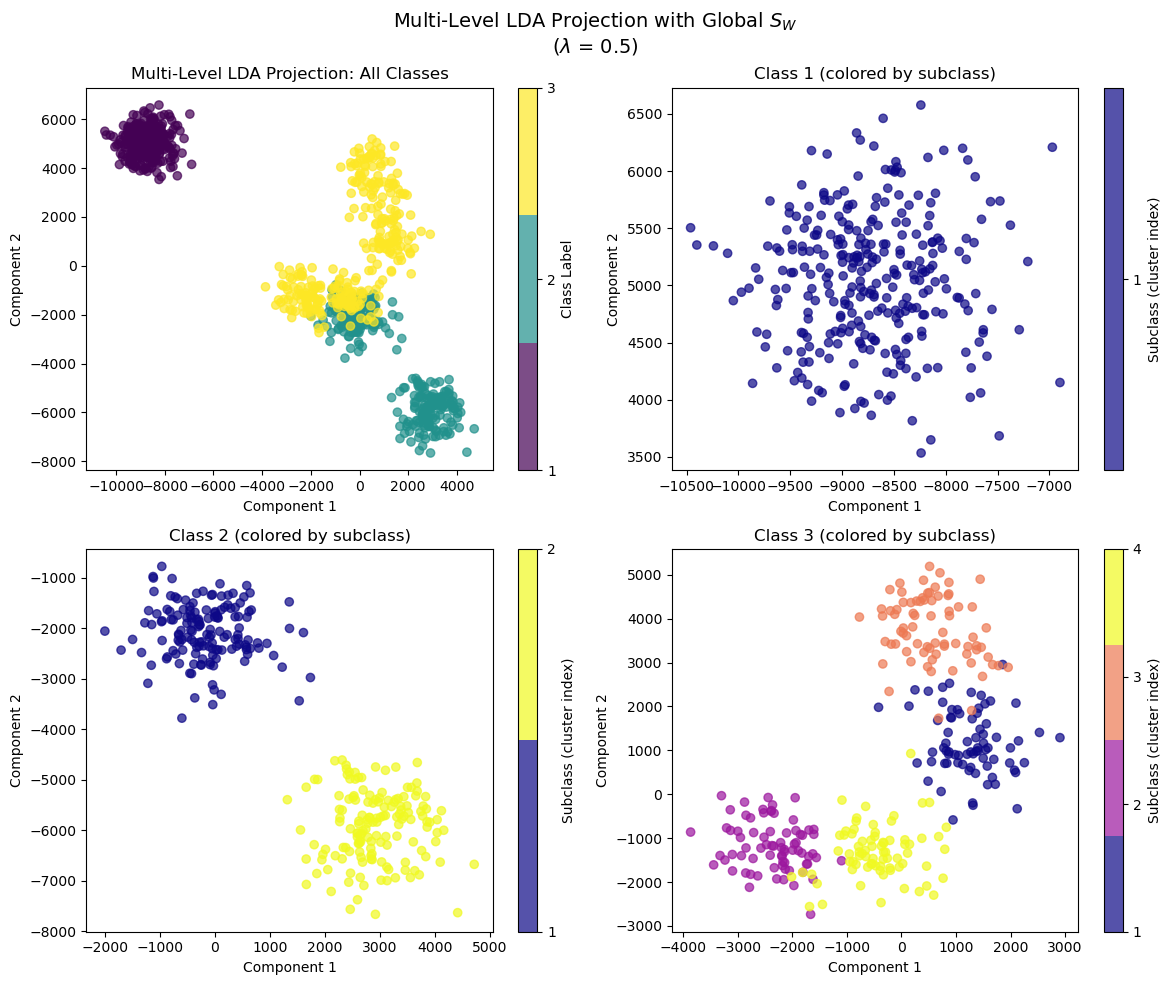

In [291]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------
# 1. Data Generation (Hierarchical Data)
# ----------------------
# We assume:
# - Parent classes: 1, 2, 3
# - Class 1 has 1 subclass; Class 2 has 2 subclasses; Class 3 has 4 subclasses.
clusters_per_class = {
    1: [300],
    2: [150, 150],
    3: [75, 75, 75, 75]
}

dims = 1000

# Spread parameters:
class_std = 2        # Controls spread of base (parent) means.
subclass_std = 100   # Controls jitter for subclass means relative to parent.
cluster_std = 20     # Controls spread for points around the subclass mean.

data_points = []    
labels_class = []     # Overall parent class labels.
labels_cluster = []   # Subclass labels (as tuples: (class_label, subclass_index)).
class_means = {}      # For storing parent means.

for class_label, cluster_sizes in clusters_per_class.items():
    # Generate a base mean for the current parent class.
    base_mean = np.random.randn(dims) * class_std
    class_means[class_label] = base_mean
    for cluster_index, n_points in enumerate(cluster_sizes, start=1):
        # Generate a subclass mean by adding jitter to the base mean.
        subclass_mean = base_mean + np.random.randn(dims) * subclass_std
        # Generate points around this subclass mean.
        points = subclass_mean + np.random.randn(n_points, dims) * cluster_std
        
        data_points.append(points)
        labels_class.extend([class_label] * n_points)
        labels_cluster.extend([(class_label, cluster_index)] * n_points)

data_points = np.vstack(data_points)
labels_class = np.array(labels_class)
labels_cluster = np.array(labels_cluster)  # Array of tuples

# ----------------------
# 2. Global Scatter Matrices (Standard Definitions)
# ----------------------
overall_mean = np.mean(data_points, axis=0)
unique_classes = np.unique(labels_class)
d = dims

# Global between-class scatter S_B.
S_B = np.zeros((d, d))
for c in unique_classes:
    idx = np.where(labels_class == c)[0]
    X_c = data_points[idx, :]
    N_c = X_c.shape[0]
    mu_c = np.mean(X_c, axis=0)
    S_B += N_c * np.outer(mu_c - overall_mean, mu_c - overall_mean)

# Global within-class scatter S_W_reg (the "regular" definition).
S_W_reg = np.zeros((d, d))
parent_means = {}  # Recompute/ensure parent means.
for c in unique_classes:
    idx = np.where(labels_class == c)[0]
    X_c = data_points[idx, :]
    mu_c = np.mean(X_c, axis=0)
    parent_means[c] = mu_c
    diff = X_c - mu_c
    S_W_reg += diff.T @ diff

# ----------------------
# 3. Local (Per-Class) Scatter Matrices (Using Subclass Structure)
# ----------------------
# For each parent class c, compute:
#    S_B^c = sum_{subclass in class c} N_{c,j} (mu_{c,j} - mu_c)(mu_{c,j} - mu_c)^T
#    S_W^c = sum_{subclass in class c} sum_{x in subclass} (x - mu_{c,j})(x - mu_{c,j})^T
local_S_B = {}   # Dictionary: local_S_B[c] for each class c.
local_S_W = {}   # Similarly, local_S_W[c].
subclass_means = {}  # Dictionary: subclass_means[c] = list of subclass means for class c.

for c in unique_classes:
    idx = np.where(labels_class == c)[0]
    X_c = data_points[idx, :]
    mu_c = np.mean(X_c, axis=0)
    subclass_means[c] = []
    
    # Identify unique subclass indices for class c.
    class_subs = np.array([lbl[1] for lbl in labels_cluster[idx]])
    unique_subs = np.unique(class_subs)
    
    S_B_c = np.zeros((d, d))
    S_W_c = np.zeros((d, d))
    
    for sub in unique_subs:
        # Find indices for subclass (c, sub).
        idx_sub = np.where(np.array([ (lbl[0] == c and lbl[1] == sub) for lbl in labels_cluster ]))[0]
        X_cs = data_points[idx_sub, :]
        N_cs = X_cs.shape[0]
        mu_cs = np.mean(X_cs, axis=0)
        subclass_means[c].append(mu_cs)
        
        diff = X_cs - mu_cs
        S_W_c += diff.T @ diff
        S_B_c += N_cs * np.outer(mu_cs - mu_c, mu_cs - mu_c)
    
    local_S_B[c] = S_B_c
    local_S_W[c] = S_W_c

# ----------------------
# 4. Define the Multi-Level Scatter Matrix Ratio Objective Function
# ----------------------
def multi_level_scatter_objective(W, lambda_val, S_B, S_W_reg, local_S_B, local_S_W, eps=1e-8):
    """
    W: Projection matrix of shape (d, r) (e.g., (1000, 2)).
    lambda_val: Balance parameter in [0,1] between global and local terms.
    S_B, S_W_reg: Global between-class and standard within-class scatter matrices.
    local_S_B, local_S_W: Dictionaries for local (per-class) scatter matrices.
    eps: Small constant to prevent division by zero.
    
    Returns:
        J(W) = λ * (tr(Wᵀ S_B W) / tr(Wᵀ S_W_reg W))
             + (1 - λ) * Σ₍c₌₁₎ᵏ (tr(Wᵀ S_B^c W) / tr(Wᵀ S_W^c W))
    """
    global_term = np.trace(W.T @ S_B @ W) / (np.trace(W.T @ S_W_reg @ W) + eps)
    
    local_term_sum = 0.0
    for c in local_S_B.keys():
        term = np.trace(W.T @ local_S_B[c] @ W) / (np.trace(W.T @ local_S_W[c] @ W) + eps)
        local_term_sum += term
        
    return lambda_val * global_term + (1 - lambda_val) * local_term_sum

# ----------------------
# 5. Evaluate the Objective and Compute a 2D Projection
# ----------------------
r = 2  # Target projection dimension (2D)
np.random.seed(2001)
W_init = np.random.randn(d, r)

# Balance parameter λ in [0,1]:
lambda_val = 0.5

obj_val = multi_level_scatter_objective(W_init, lambda_val, S_B, S_W_reg, local_S_B, local_S_W)
print("Multi-level scatter objective value:", obj_val)

# Project the data into 2D using the current projection matrix W_init.
data_points_2d = data_points @ W_init

# ----------------------
# 6. Plot the Projected Data
# ----------------------
# Create a 2×2 grid of subplots.
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.tight_layout(pad=4.0)

# Plot 1: Overall projection (points colored by parent class) using a discrete colormap.
num_classes = len(unique_classes)
discrete_cmap_all = plt.cm.get_cmap('viridis', num_classes)
ax = axs[0, 0]
scatter_all = ax.scatter(data_points_2d[:, 0], data_points_2d[:, 1],
                         c=labels_class, cmap=discrete_cmap_all, alpha=0.7)
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_title("Multi-Level LDA Projection: All Classes")
cbar_all = fig.colorbar(scatter_all, ax=ax, ticks=unique_classes)
cbar_all.set_label('Class Label')
cbar_all.ax.set_yticklabels(unique_classes)

# Plot 2-4: For each parent class, create a subplot with points colored by subclass.
positions = [(0, 1), (1, 0), (1, 1)]
for pos, c in zip(positions, unique_classes):
    i, j = pos
    ax = axs[i, j]
    idx = np.where(labels_class == c)[0]
    data_c_2d = data_points_2d[idx]
    # Extract subclass labels (the second element of each tuple).
    subclass_vals = np.array([lbl[1] for lbl in labels_cluster[idx]])
    unique_subclasses = np.unique(subclass_vals)
    discrete_cmap_sub = plt.cm.get_cmap('plasma', len(unique_subclasses))
    
    scatter_sub = ax.scatter(data_c_2d[:, 0], data_c_2d[:, 1],
                             c=subclass_vals, cmap=discrete_cmap_sub, alpha=0.7)
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.set_title(f"Class {c} (colored by subclass)")
    cbar_sub = fig.colorbar(scatter_sub, ax=ax, ticks=unique_subclasses)
    cbar_sub.set_label("Subclass (cluster index)")
    cbar_sub.ax.set_yticklabels(unique_subclasses)
plt.suptitle(f"Multi-Level LDA Projection with Global $S_W$\n($\lambda$ = {lambda_val})", fontsize=14)
plt.tight_layout()

plt.show()


Fold 1 – Training Objective Value: 2.2485


/var/folders/zd/c5dfjvdd3850xf529yxpdznw0000gq/T/ipykernel_37767/1609550564.py:162: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  discrete_cmap_all = plt.cm.get_cmap('viridis', len(unique_all_classes))
/var/folders/zd/c5dfjvdd3850xf529yxpdznw0000gq/T/ipykernel_37767/1609550564.py:196: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  discrete_cmap_sub = plt.cm.get_cmap('plasma', len(unique_subs))


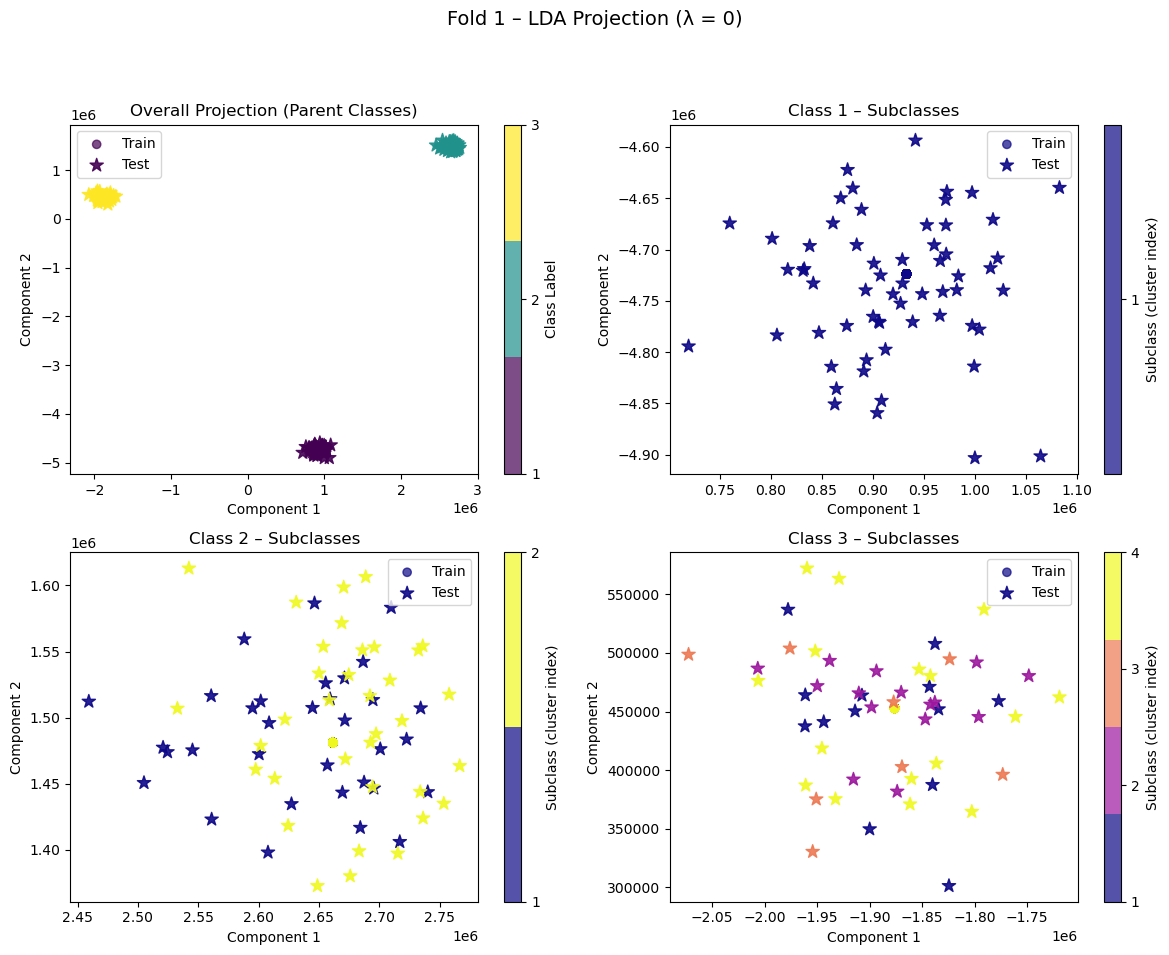

Fold 2 – Training Objective Value: -70.1024


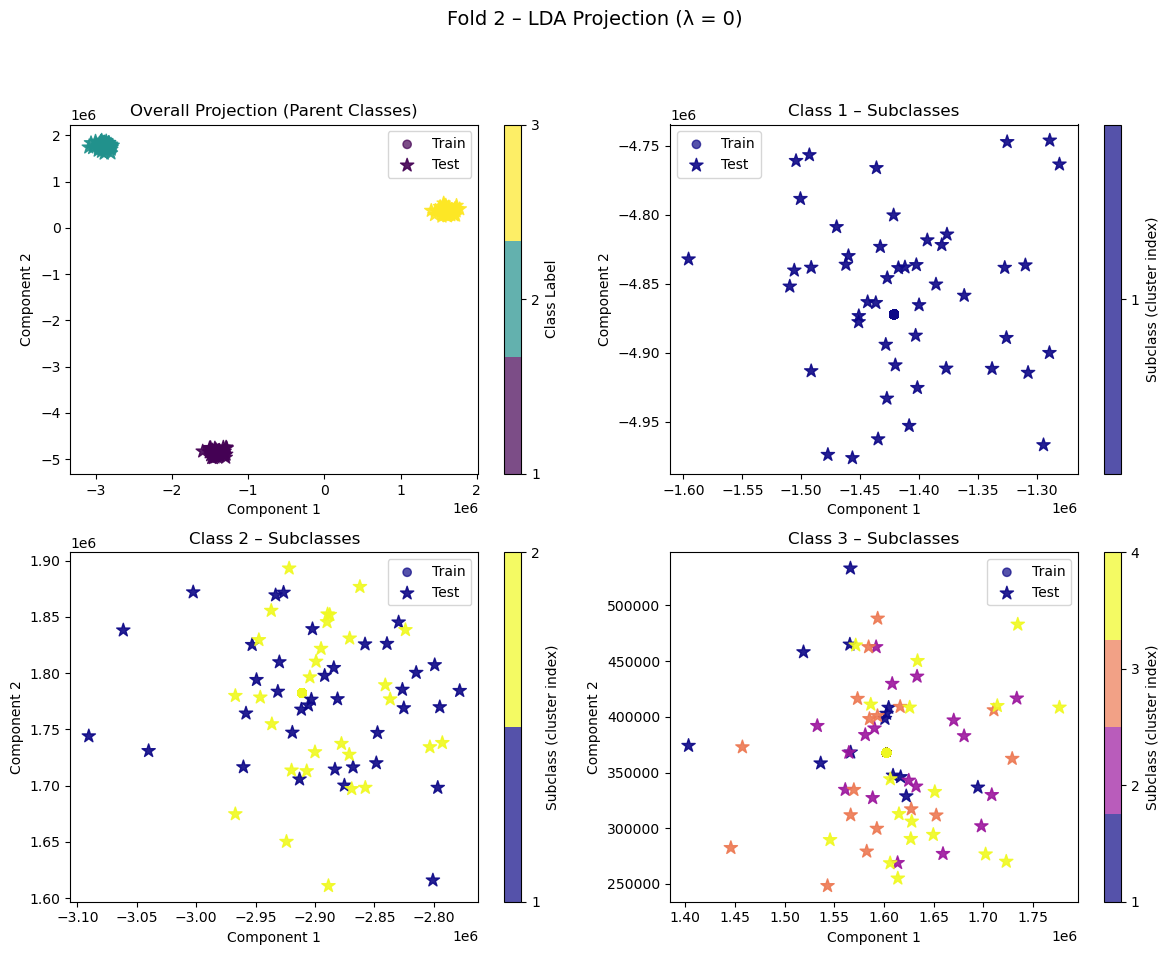

Fold 3 – Training Objective Value: -83.1583


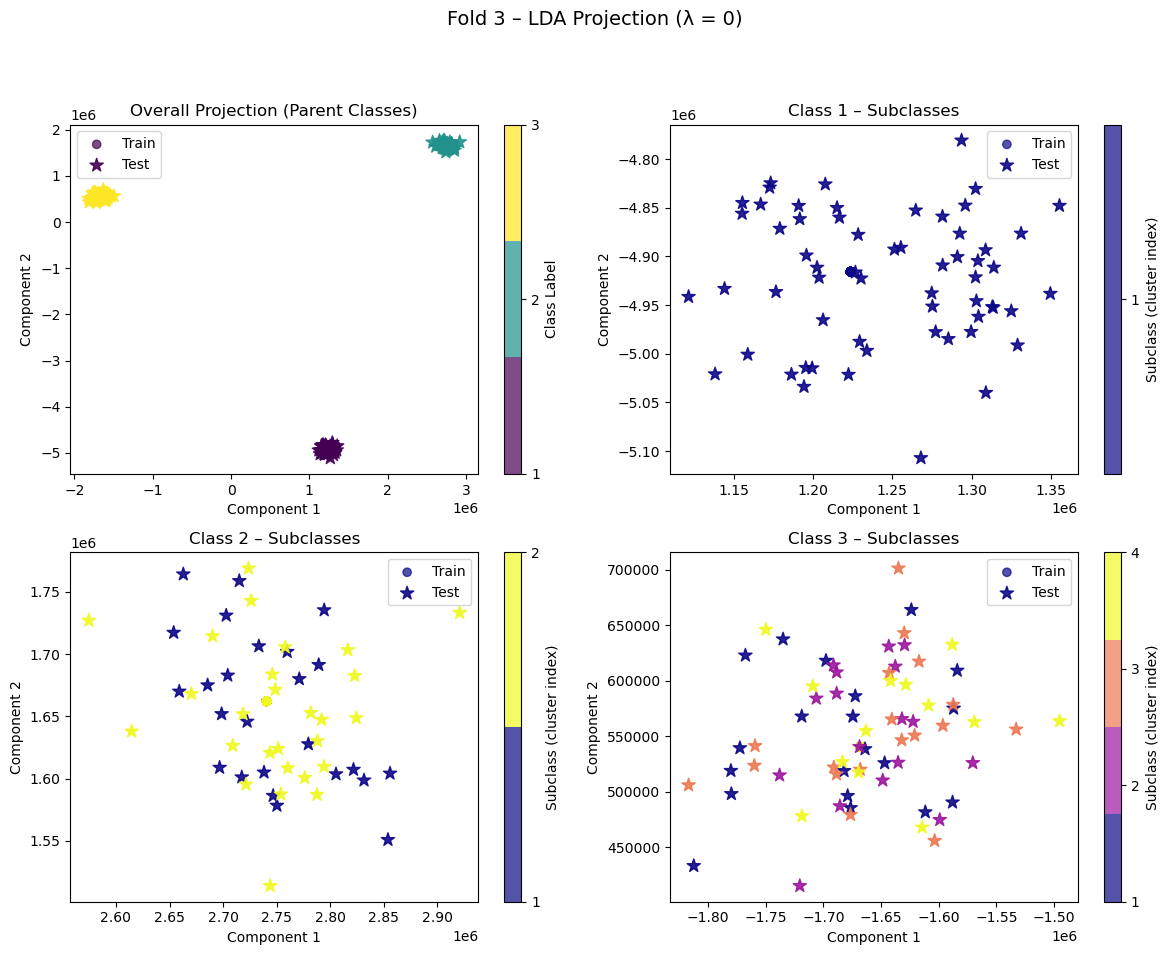

Fold 4 – Training Objective Value: -41.2468


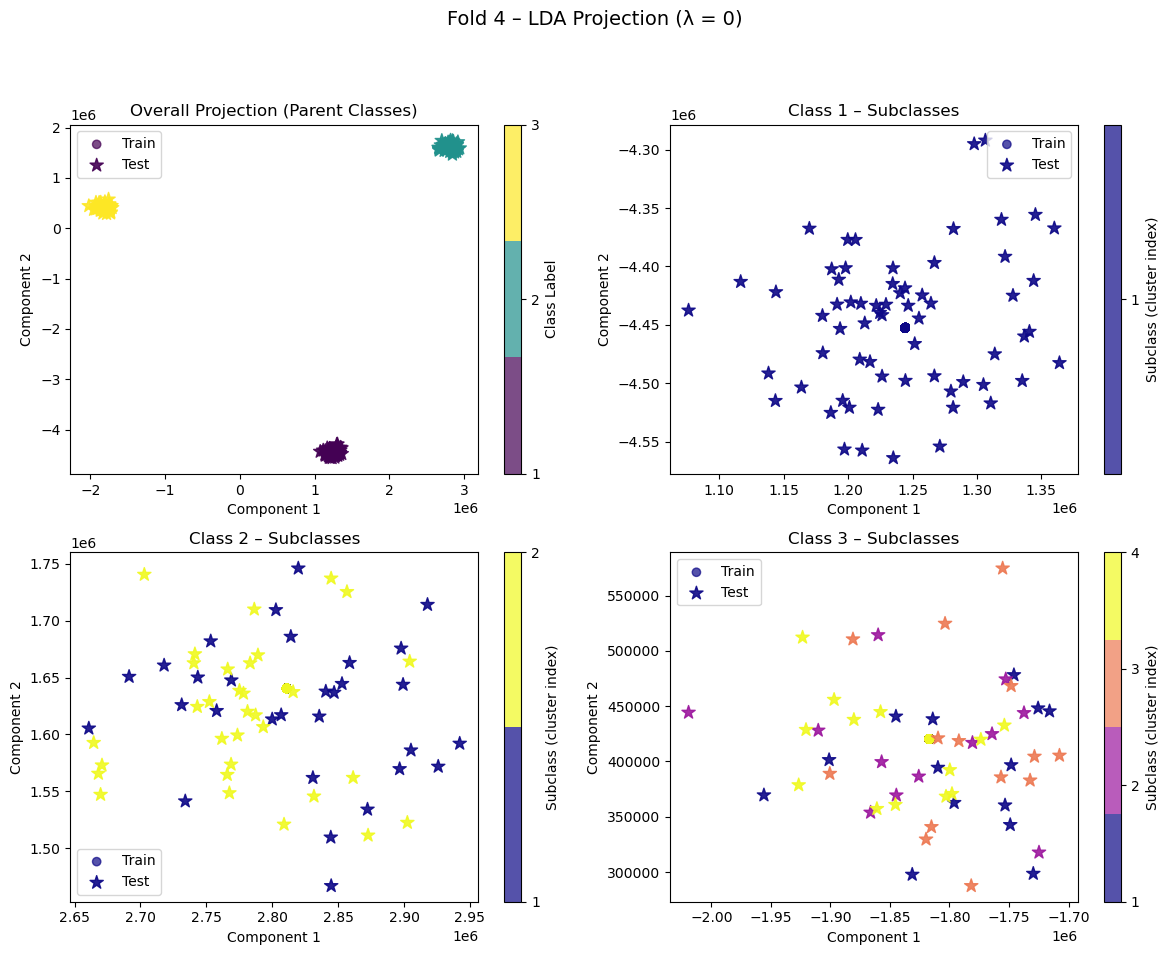

Fold 5 – Training Objective Value: 22.3461


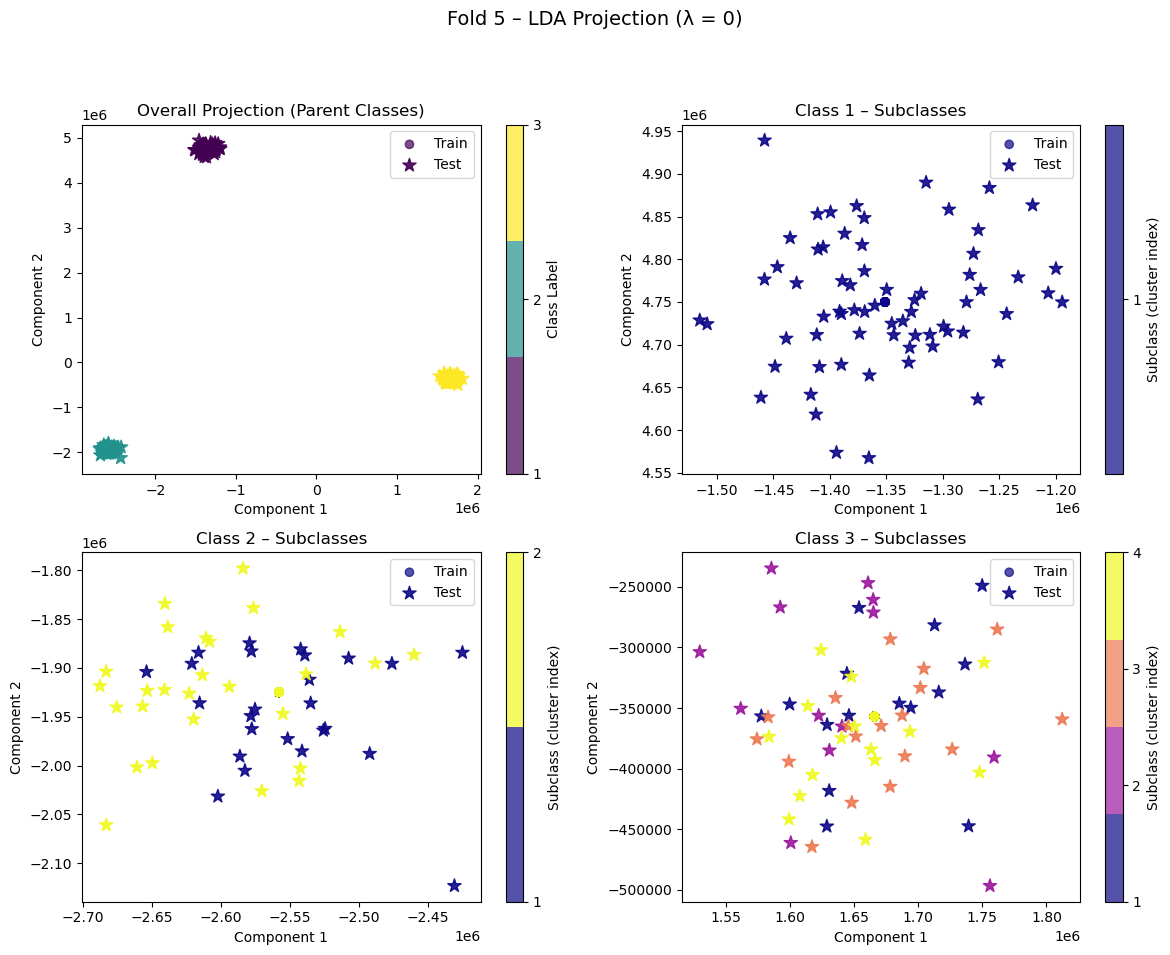

In [280]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from sklearn.model_selection import KFold

# ----------------------
# 1. Data Generation (Hierarchical Data)
# ----------------------
# We assume:
# - Parent classes: 1, 2, 3
# - Class 1 has 1 subclass; Class 2 has 2 subclasses; Class 3 has 4 subclasses.
clusters_per_class = {
    1: [300],
    2: [150, 150],
    3: [75, 75, 75, 75]
}

dims = 1000

# Spread parameters:
class_std = 2        # Controls spread of base (parent) means.
subclass_std = 100   # Controls jitter for subclass means relative to parent.
cluster_std = 20     # Controls spread for points around the subclass mean.

data_points = []    
labels_class = []     # Overall parent class labels.
labels_cluster = []   # Subclass labels (as tuples: (class_label, subclass_index)).
class_means = {}      # For storing parent means.

for class_label, cluster_sizes in clusters_per_class.items():
    base_mean = np.random.randn(dims) * class_std
    class_means[class_label] = base_mean
    for cluster_index, n_points in enumerate(cluster_sizes, start=1):
        subclass_mean = base_mean + np.random.randn(dims) * subclass_std
        points = subclass_mean + np.random.randn(n_points, dims) * cluster_std
        
        data_points.append(points)
        labels_class.extend([class_label] * n_points)
        labels_cluster.extend([(class_label, cluster_index)] * n_points)

data_points = np.vstack(data_points)
labels_class = np.array(labels_class)
labels_cluster = np.array(labels_cluster)  # Array of tuples

# ----------------------
# 2. Define the Multi–Level Scatter Matrix Ratio Objective Function
# ----------------------
def multi_level_scatter_objective(W, lambda_val, S_B, S_W_reg, local_S_B, local_S_W, eps=1e-8):
    """
    W: Projection matrix (d, r).
    lambda_val: Balance parameter between global and local terms.
    S_B, S_W_reg: Global between– and within–class scatter matrices.
    local_S_B, local_S_W: Dictionaries of local (per–class) scatter matrices.
    eps: To avoid division by zero.
    
    Returns:
        The multi–level scatter objective value:
            J(W) = λ * (tr(Wᵀ S_B W) / tr(Wᵀ S_W_reg W))
                 + (1 – λ) * Σ_{c} [tr(Wᵀ S_B^c W) / tr(Wᵀ S_W^c W)]
    """
    global_term = np.trace(W.T @ S_B @ W) / (np.trace(W.T @ S_W_reg @ W) + eps)
    local_term_sum = 0.0
    for c in local_S_B.keys():
        term = np.trace(W.T @ local_S_B[c] @ W) / (np.trace(W.T @ local_S_W[c] @ W) + eps)
        local_term_sum += term
    return lambda_val * global_term + (1 - lambda_val) * local_term_sum

# ----------------------
# 3. K–Fold Cross Validation Setup
# ----------------------
kf = KFold(n_splits=5, shuffle=True, random_state=2001)
lambda_val = 0  # Using only the global term (simplifies to standard LDA)
fold = 1

for train_index, test_index in kf.split(data_points):
    # Split the data into training and test sets.
    X_train, X_test = data_points[train_index], data_points[test_index]
    y_train_class, y_test_class = labels_class[train_index], labels_class[test_index]
    y_train_cluster, y_test_cluster = labels_cluster[train_index], labels_cluster[test_index]
    
    d = dims  # dimension
    # --------------
    # Compute Global Scatter Matrices for the Training Set.
    overall_mean_train = np.mean(X_train, axis=0)
    unique_train_classes = np.unique(y_train_class)
    
    S_B_train = np.zeros((d, d))
    S_W_train = np.zeros((d, d))
    
    # Also compute parent means for training data.
    parent_means_train = {}
    
    for c in unique_train_classes:
        idx = np.where(y_train_class == c)[0]
        X_c = X_train[idx]
        mu_c = np.mean(X_c, axis=0)
        parent_means_train[c] = mu_c
        N_c = X_c.shape[0]
        S_B_train += N_c * np.outer(mu_c - overall_mean_train, mu_c - overall_mean_train)
        diff = X_c - mu_c
        S_W_train += diff.T @ diff
        
    # --------------
    # Compute Local (Per–Class) Scatter Matrices for the Training Set.
    local_S_B_train = {}
    local_S_W_train = {}
    subclass_means_train = {}  # Store subclass means (if needed)
    
    for c in unique_train_classes:
        idx = np.where(y_train_class == c)[0]
        X_c = X_train[idx]
        mu_c = np.mean(X_c, axis=0)
        subclass_means_train[c] = []
        
        # Get the subclass labels for class c from training set.
        class_subs = np.array([lbl[1] for lbl in y_train_cluster[idx]])
        unique_subs = np.unique(class_subs)
    
        S_B_c = np.zeros((d, d))
        S_W_c = np.zeros((d, d))
    
        for sub in unique_subs:
            # Filter indices for subclass (c, sub) within training set.
            idx_sub = np.where(np.array([ (lbl[0] == c and lbl[1] == sub) for lbl in y_train_cluster ]))[0]
            X_cs = X_train[idx_sub]
            N_cs = X_cs.shape[0]
            mu_cs = np.mean(X_cs, axis=0)
            subclass_means_train[c].append(mu_cs)
    
            diff = X_cs - mu_cs
            S_W_c += diff.T @ diff
            S_B_c += N_cs * np.outer(mu_cs - mu_c, mu_cs - mu_c)
    
        local_S_B_train[c] = S_B_c
        local_S_W_train[c] = S_W_c
    
    # --------------
    # For λ = 1, the objective reduces to the global term.
    # Here we compute the projection matrix W using a closed–form solution (generalized eigen–problem).
    reg = 1e-7 * np.eye(d)
    eigvals, eigvecs = eigh(S_B_train, S_W_train + reg)
    # Select the eigenvectors for the two largest eigenvalues.
    W = eigvecs[:, -2:]
    
    # Optionally, print the decision function (objective value) on the training set.
    obj_train = multi_level_scatter_objective(W, lambda_val, S_B_train, S_W_train, local_S_B_train, local_S_W_train)
    print(f"Fold {fold} – Training Objective Value: {obj_train:.4f}")
    
    # --------------
    # Project both training and test data into 2D using the computed projection matrix.
    proj_train = X_train @ W
    proj_test  = X_test @ W
    
    # ----------------------
    # 4. Plot the Projections for This Fold
    # ----------------------
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f"Fold {fold} – LDA Projection (λ = {lambda_val})", fontsize=14)
    
    # Overall projection plot: parent classes (training: circles, test: stars)
    unique_all_classes = np.unique(labels_class)
    discrete_cmap_all = plt.cm.get_cmap('viridis', len(unique_all_classes))
    ax = axs[0, 0]
    sc_train = ax.scatter(proj_train[:, 0], proj_train[:, 1],
                          c=y_train_class, cmap=discrete_cmap_all, marker='o', alpha=0.7, label='Train')
    sc_test = ax.scatter(proj_test[:, 0], proj_test[:, 1],
                         c=y_test_class, cmap=discrete_cmap_all, marker='*', s=100, alpha=0.9, label='Test')
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.set_title("Overall Projection (Parent Classes)")
    cbar = fig.colorbar(sc_train, ax=ax, ticks=unique_all_classes)
    cbar.set_label('Class Label')
    ax.legend()
    
    # Per–class subplot: subclass coloring (for classes 1, 2, 3)
    # Define subplot positions for classes 1, 2, 3 (if not all classes appear in a fold, adjust accordingly)
    class_positions = {1: (0, 1), 2: (1, 0), 3: (1, 1)}
    
    for c, pos in class_positions.items():
        if c not in unique_train_classes:
            continue  # Skip if the class c is missing in this fold.
        i, j = pos
        ax = axs[i, j]
    
        # Filter training and test points by parent class c.
        train_mask = (y_train_class == c)
        test_mask = (y_test_class == c)
        proj_train_c = proj_train[train_mask]
        proj_test_c  = proj_test[test_mask]
    
        # For subclass coloring: extract subclass label from each tuple.
        train_sub_labels = np.array([lbl[1] for lbl in y_train_cluster[train_mask]])
        test_sub_labels  = np.array([lbl[1] for lbl in y_test_cluster[test_mask]])
        # Use union of subclass labels (in case one fold misses some subclass samples).
        unique_subs = np.unique(np.concatenate([train_sub_labels, test_sub_labels]))
        discrete_cmap_sub = plt.cm.get_cmap('plasma', len(unique_subs))
    
        sc_train = ax.scatter(proj_train_c[:, 0], proj_train_c[:, 1],
                              c=train_sub_labels, cmap=discrete_cmap_sub, marker='o', alpha=0.7, label='Train')
        sc_test = ax.scatter(proj_test_c[:, 0], proj_test_c[:, 1],
                             c=test_sub_labels, cmap=discrete_cmap_sub, marker='*', s=100, alpha=0.9, label='Test')
    
        ax.set_xlabel("Component 1")
        ax.set_ylabel("Component 2")
        ax.set_title(f"Class {c} – Subclasses")
        cbar_sub = fig.colorbar(sc_train, ax=ax, ticks=unique_subs)
        cbar_sub.set_label("Subclass (cluster index)")
        ax.legend()
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    fold += 1


# Multi-level Scatter Ratio

Multi-level scatter objective value: 0.8084988041413339


/var/folders/zd/c5dfjvdd3850xf529yxpdznw0000gq/T/ipykernel_37767/3814954584.py:145: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  discrete_cmap_all = plt.cm.get_cmap('viridis', num_classes)
/var/folders/zd/c5dfjvdd3850xf529yxpdznw0000gq/T/ipykernel_37767/3814954584.py:166: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  discrete_cmap_sub = plt.cm.get_cmap('plasma', len(unique_subclasses))
/var/folders/zd/c5dfjvdd3850xf529yxpdznw0000gq/T/ipykernel_37767/3814954584.py:166: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.color

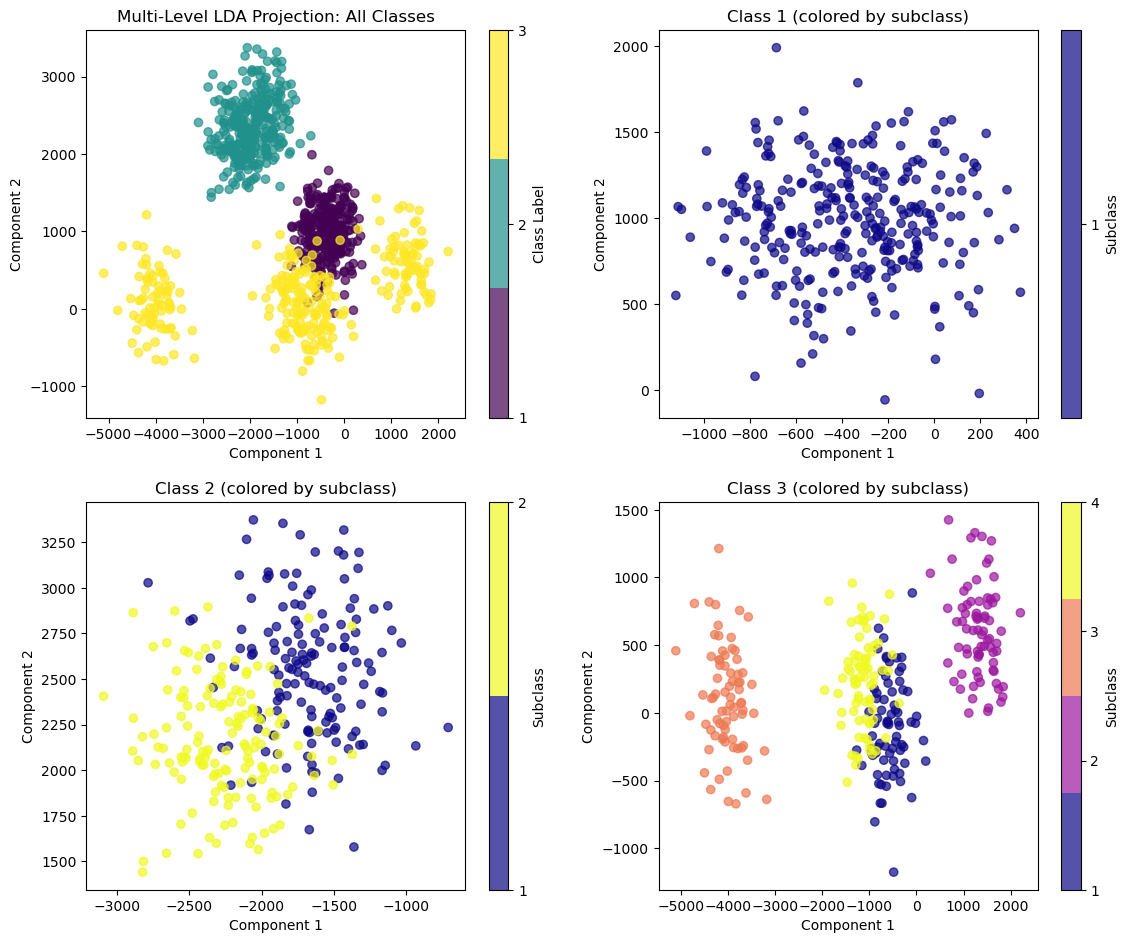

In [264]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------
# 1. Data Generation (Hierarchical Data)
# ----------------------
# Suppose we have:
# - Class 1: 1 subclass with 300 points.
# - Class 2: 2 subclasses with 150 points each.
# - Class 3: 4 subclasses with 75 points each.
clusters_per_class = {
    1: [300],
    2: [150, 150],
    3: [75, 75, 75, 75]
}

dims = 1000

# Standard deviation parameters (to control spread)
class_std = 100      # Spread of parent class base means.
subclass_std = 50    # Jitter added to parent base mean to get subclass mean.
cluster_std = 10     # Spread of individual points around the subclass mean.

data_points = []    
labels_class = []     # Parent (global) class label per point.
labels_cluster = []   # Subclass label, stored as (parent_class, subclass_index).

for class_label, cluster_sizes in clusters_per_class.items():
    # Generate a base (parent) mean in dims dimensions.
    base_mean = np.random.randn(dims) * class_std
    for cluster_index, n_points in enumerate(cluster_sizes, start=1):
        # Generate a subclass mean by adding jitter to the base mean.
        subclass_mean = base_mean + np.random.randn(dims) * subclass_std
        # Generate points from a Gaussian distribution centered at subclass_mean.
        points = subclass_mean + np.random.randn(n_points, dims) * cluster_std
        
        data_points.append(points)
        labels_class.extend([class_label] * n_points)
        labels_cluster.extend([(class_label, cluster_index)] * n_points)

data_points = np.vstack(data_points)
labels_class = np.array(labels_class)
labels_cluster = np.array(labels_cluster)  # Each entry is a tuple.

# ----------------------
# 2. Compute Global Scatter Matrices
# ----------------------
overall_mean = np.mean(data_points, axis=0)
unique_classes = np.unique(labels_class)
d = dims

# Global between-class scatter S_B and within-class scatter S_W:
S_B = np.zeros((d, d))
S_W = np.zeros((d, d))
parent_means = {}  # Will hold the mean for each parent class.

for c in unique_classes:
    idx = np.where(labels_class == c)[0]
    X_c = data_points[idx]
    mu_c = np.mean(X_c, axis=0)
    parent_means[c] = mu_c
    S_B += X_c.shape[0] * np.outer(mu_c - overall_mean, mu_c - overall_mean)
    diff = X_c - mu_c
    S_W += diff.T @ diff

# ----------------------
# 3. Compute Local (Per-Class) Scatter Matrices
# ----------------------
# For each parent class i, we compute:
#  S_B^i = sum_{j} N_{ij} (mu_{ij} - mu_i)(mu_{ij} - mu_i)^T   (between-subclass scatter)
#  S_W^i = sum_{j} sum_{x in subclass j} (x - mu_{ij})(x - mu_{ij})^T   (within-subclass scatter)
local_S_B = {}   # Dictionary: for each class c, local_S_B[c] = S_B^c.
local_S_W = {}   # Similarly for local_S_W.
for c in unique_classes:
    idx = np.where(labels_class == c)[0]
    X_c = data_points[idx]
    mu_c = parent_means[c]
    # Identify unique subclass indices for class c.
    # (labels_cluster entries are tuples (c, subclass_index))
    subclass_ids = np.unique([lbl[1] for lbl in labels_cluster[idx]])
    S_B_i = np.zeros((d, d))
    S_W_i = np.zeros((d, d))
    for sub in subclass_ids:
        # Find indices of points belonging to subclass (c, sub)
        idx_sub = np.where(np.array([ (lbl[0] == c and lbl[1] == sub) for lbl in labels_cluster ]))[0]
        X_cs = data_points[idx_sub]
        N_cs = X_cs.shape[0]
        mu_cs = np.mean(X_cs, axis=0)
        # Accumulate within-subclass scatter.
        diff = X_cs - mu_cs
        S_W_i += diff.T @ diff
        # Accumulate between-subclass scatter (how much the subclass mean deviates from parent class mean).
        S_B_i += N_cs * np.outer(mu_cs - mu_c, mu_cs - mu_c)
    local_S_B[c] = S_B_i
    local_S_W[c] = S_W_i

# ----------------------
# 4. Define the Multi-Level Scatter Matrix Ratio Objective
# ----------------------
def multi_level_scatter_objective(W, lambda_val, S_B, S_W, local_S_B, local_S_W, eps=1e-8):
    """
    W: Projection matrix of shape (d, r) (e.g. from 1000D to r-D).
    lambda_val: Balance parameter in [0,1] between global and local terms.
    S_B, S_W: Global between-class and within-class scatter matrices.
    local_S_B, local_S_W: Dictionaries of local scatter matrices per parent class.
    eps: Small constant to prevent division by zero.
    
    Returns:
        J(W) = λ * (tr(Wᵀ S_B W) / tr(Wᵀ S_W W)) + (1 - λ) * Σ₍ᵢ₌₁₎ᵏ (tr(Wᵀ S_B^i W) / tr(Wᵀ S_W^i W))
    """
    global_term = np.trace(W.T @ S_B @ W) / (np.trace(W.T @ S_W @ W) + eps)
    
    local_term_sum = 0.0
    for c in local_S_B.keys():
        term = np.trace(W.T @ local_S_B[c] @ W) / (np.trace(W.T @ local_S_W[c] @ W) + eps)
        local_term_sum += term
        
    return lambda_val * global_term + (1 - lambda_val) * local_term_sum

# ----------------------
# 5. Evaluate the Objective and Compute a 2D Projection
# ----------------------
r = 2  # Target projection dimension (2D)
np.random.seed(2001)
W_init = np.random.randn(d, r)

# Balance parameter λ ∈ [0,1]
lambda_val = 1

obj_val = multi_level_scatter_objective(W_init, lambda_val, S_B, S_W, local_S_B, local_S_W)
print("Multi-level scatter objective value:", obj_val)

# Project the data into 2D using the current W.
data_points_2d = data_points @ W_init

# ----------------------
# 6. Plotting
# ----------------------
# We produce a 2×2 grid: one overall plot and one per parent class.
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.tight_layout(pad=4.0)

# Overall plot: color points by parent class.
num_classes = len(unique_classes)
discrete_cmap_all = plt.cm.get_cmap('viridis', num_classes)
ax = axs[0, 0]
scatter_all = ax.scatter(data_points_2d[:, 0], data_points_2d[:, 1],
                         c=labels_class, cmap=discrete_cmap_all, alpha=0.7)
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_title("Multi-Level LDA Projection: All Classes")
cbar_all = fig.colorbar(scatter_all, ax=ax, ticks=unique_classes)
cbar_all.set_label("Class Label")
cbar_all.ax.set_yticklabels(unique_classes)

# For per-class plots, use the remaining three subplots.
positions = [(0, 1), (1, 0), (1, 1)]
for pos, c in zip(positions, unique_classes):
    i, j = pos
    ax = axs[i, j]
    idx = np.where(labels_class == c)[0]
    data_c_2d = data_points_2d[idx]
    # Extract subclass labels (the second element of each tuple).
    subclass_vals = np.array([lbl[1] for lbl in labels_cluster[idx]])
    unique_subclasses = np.unique(subclass_vals)
    discrete_cmap_sub = plt.cm.get_cmap('plasma', len(unique_subclasses))
    
    scatter_sub = ax.scatter(data_c_2d[:, 0], data_c_2d[:, 1],
                             c=subclass_vals, cmap=discrete_cmap_sub, alpha=0.7)
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.set_title(f"Class {c} (colored by subclass)")
    cbar_sub = fig.colorbar(scatter_sub, ax=ax, ticks=unique_subclasses)
    cbar_sub.set_label("Subclass")
    cbar_sub.ax.set_yticklabels(unique_subclasses)

plt.show()


# test

Iter 0: Obj=253.6312, alpha=0.5001, lambda1=0.5000, lambda2=0.5476
Iter 50: Obj=88321.3703, alpha=0.5373, lambda1=0.5003, lambda2=18.3884
Iter 100: Obj=194833.4031, alpha=0.5655, lambda1=0.5004, lambda2=42.0205
Iter 150: Obj=283318.6584, alpha=0.6097, lambda1=0.5004, lambda2=64.6341
Iter 200: Obj=332933.0360, alpha=0.7039, lambda1=0.5005, lambda2=85.5275
Iter 250: Obj=76405.8893, alpha=1.0000, lambda1=0.5007, lambda2=97.3114
Iter 300: Obj=71630.4914, alpha=1.0000, lambda1=0.5009, lambda2=100.8676
Iter 350: Obj=72154.8430, alpha=1.0000, lambda1=0.5011, lambda2=104.4718
Iter 400: Obj=70626.5437, alpha=1.0000, lambda1=0.5014, lambda2=108.1491
Iter 450: Obj=93614.8213, alpha=1.0000, lambda1=0.5016, lambda2=111.8113
Best Obj: 90956.41276315643
Best alpha: 1.0
Best lambda1: 0.5018594343926146
Best lambda2: 115.52531501780868
Iter 0: Obj=314.3038, alpha=0.5002, lambda1=0.5000, lambda2=0.5583
Iter 50: Obj=69709.7538, alpha=0.6036, lambda1=0.5002, lambda2=14.6353
Iter 100: Obj=158048.3690, alph

/var/folders/zd/c5dfjvdd3850xf529yxpdznw0000gq/T/ipykernel_37767/1784145367.py:164: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  discrete_cmap = plt.cm.get_cmap('viridis', len(np.unique(y_train)))


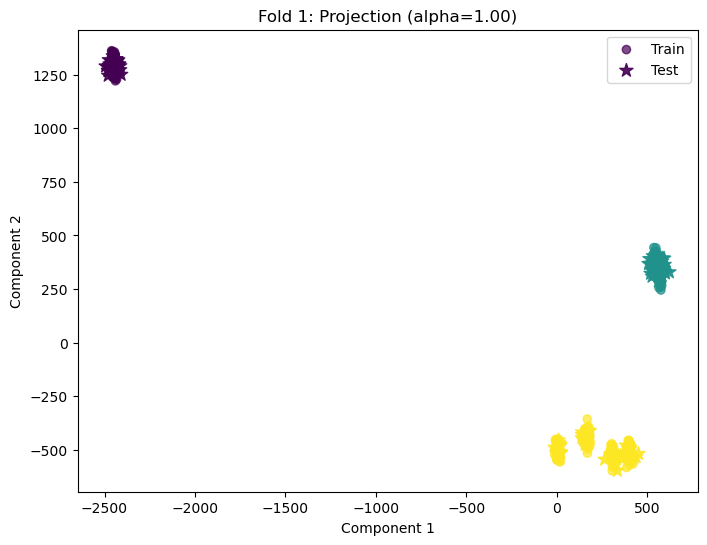

Iter 0: Obj=307.4522, alpha=0.5005, lambda1=0.5000, lambda2=0.5592
Iter 50: Obj=52808.1311, alpha=0.5881, lambda1=0.5009, lambda2=14.3101
Iter 100: Obj=118291.3076, alpha=0.6033, lambda1=0.5012, lambda2=32.6130
Iter 150: Obj=179184.9061, alpha=0.6233, lambda1=0.5015, lambda2=50.5557
Iter 200: Obj=233197.3389, alpha=0.6518, lambda1=0.5017, lambda2=68.0119
Iter 250: Obj=275195.4450, alpha=0.6985, lambda1=0.5020, lambda2=84.7515


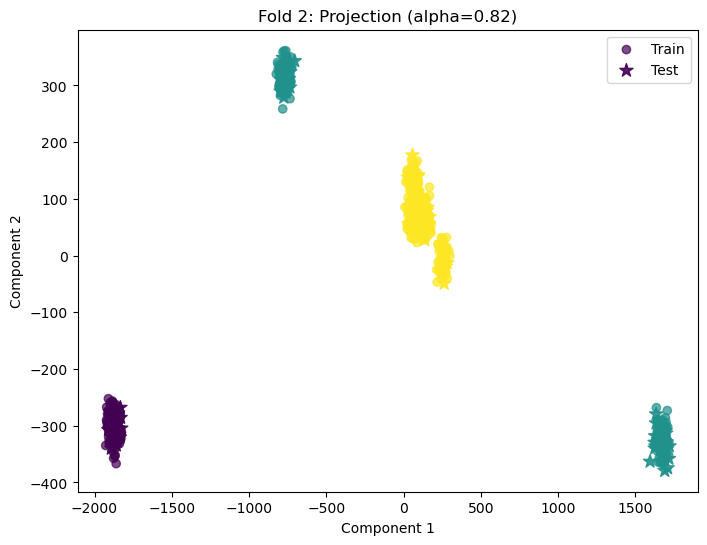

Iter 0: Obj=211.9922, alpha=0.5004, lambda1=0.5000, lambda2=0.5428
Iter 50: Obj=52618.7952, alpha=0.5319, lambda1=0.5001, lambda2=16.0884
Iter 100: Obj=19520.8054, alpha=0.7322, lambda1=0.5002, lambda2=29.4780
Iter 150: Obj=30856.9095, alpha=1.0000, lambda1=0.5004, lambda2=34.7718
Iter 200: Obj=25042.1555, alpha=1.0000, lambda1=0.5007, lambda2=38.2662
Iter 250: Obj=34349.8932, alpha=1.0000, lambda1=0.5009, lambda2=41.6531


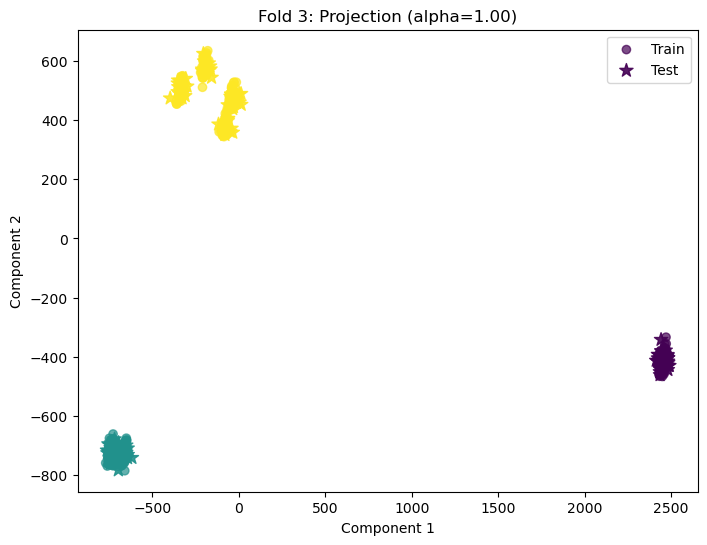

Iter 0: Obj=294.6118, alpha=0.5001, lambda1=0.5000, lambda2=0.5547
Iter 50: Obj=7462.6297, alpha=1.0000, lambda1=0.5003, lambda2=6.4086
Iter 100: Obj=9359.7970, alpha=1.0000, lambda1=0.5005, lambda2=10.3153
Iter 150: Obj=17013.3981, alpha=1.0000, lambda1=0.5007, lambda2=14.2196
Iter 200: Obj=13979.8287, alpha=1.0000, lambda1=0.5009, lambda2=18.0646
Iter 250: Obj=27444.5464, alpha=1.0000, lambda1=0.5011, lambda2=22.3473


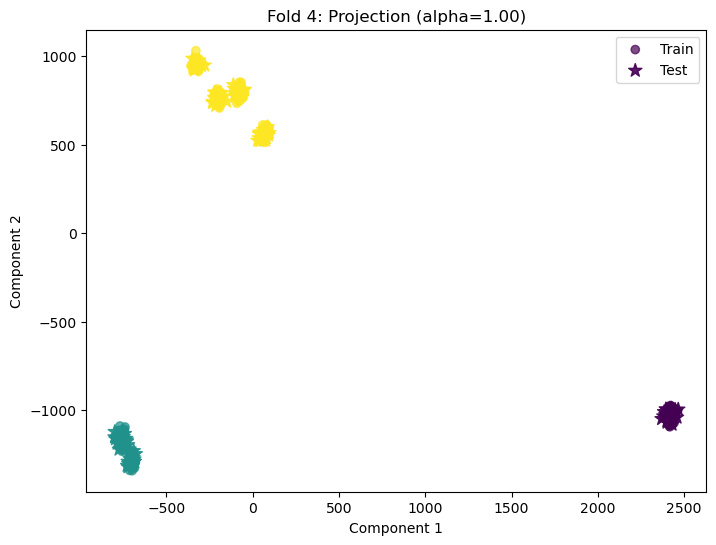

Iter 0: Obj=414.5579, alpha=0.5003, lambda1=0.5000, lambda2=0.5741
Iter 50: Obj=161825.3837, alpha=0.6219, lambda1=0.5001, lambda2=22.4925
Iter 100: Obj=412423.6126, alpha=0.6481, lambda1=0.5001, lambda2=58.2080
Iter 150: Obj=647908.4970, alpha=0.6846, lambda1=0.5001, lambda2=93.3053
Iter 200: Obj=860041.4834, alpha=0.7444, lambda1=0.5002, lambda2=127.5667
Iter 250: Obj=648181.0034, alpha=1.0000, lambda1=0.5002, lambda2=159.9242


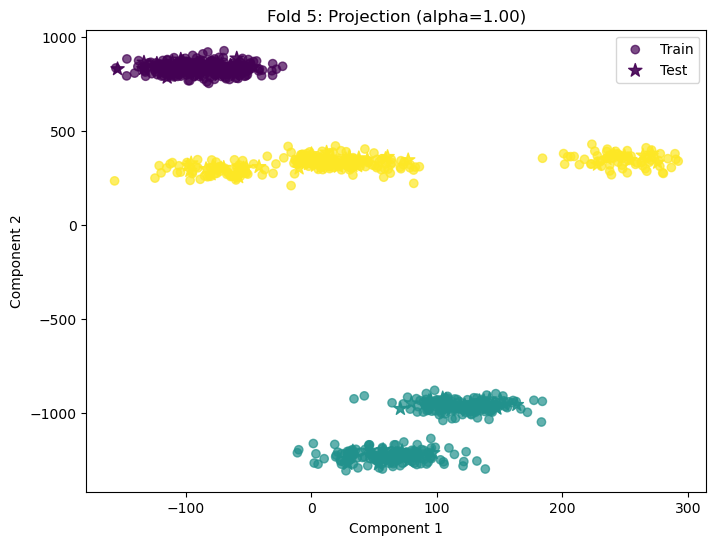

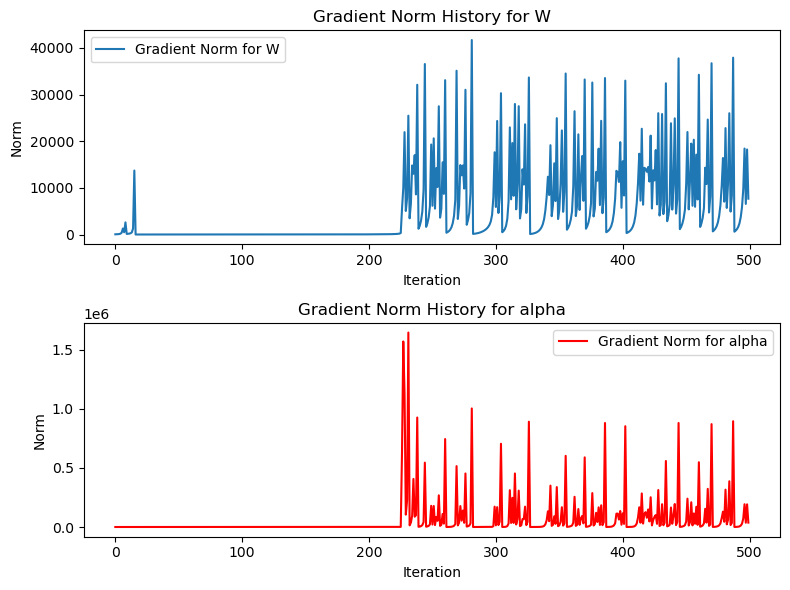

In [288]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from sklearn.model_selection import KFold

# ----------------------
# 1. Data Generation (Hierarchical Data)
# ----------------------
clusters_per_class = {1: [300], 2: [150, 150], 3: [75, 75, 75, 75]}
dims = 1000
class_std = 2
subclass_std = 100
cluster_std = 20
class_means = {
    1: np.pad([100], (0, dims - 1)),
    2: np.pad([0, 100], (0, dims - 2)),
    3: np.pad([0, 0, 100], (0, dims - 3))
}
data_points = []    
labels_class = []    
labels_cluster = []
for class_label, cluster_sizes in clusters_per_class.items():
    base_mean = class_means[class_label]
    for cluster_index, n_points in enumerate(cluster_sizes, start=1):
        subclass_mean = base_mean + np.random.randn(dims) * subclass_std
        points = subclass_mean + np.random.randn(n_points, dims) * cluster_std
        data_points.append(points)
        labels_class.extend([class_label] * n_points)
        labels_cluster.extend([(class_label, cluster_index)] * n_points)
data_points = np.vstack(data_points)
labels_class = np.array(labels_class)
labels_cluster = np.array(labels_cluster)

# ----------------------
# 2. Compute Scatter Matrices and Hierarchical Means (for a given dataset)
# ----------------------
def compute_scatter_matrices(data, labels_class, labels_cluster, dims):
    overall_mean = np.mean(data, axis=0)
    unique_classes = np.unique(labels_class)
    S_B = np.zeros((dims, dims))
    for c in unique_classes:
        idx = np.where(labels_class == c)[0]
        X_c = data[idx, :]
        N_c = X_c.shape[0]
        mu_c = np.mean(X_c, axis=0)
        S_B += N_c * np.outer(mu_c - overall_mean, mu_c - overall_mean)
    S_WS = np.zeros((dims, dims))
    S_BS = np.zeros((dims, dims))
    parent_means = {}
    subclass_means = {}
    for c in unique_classes:
        idx = np.where(labels_class == c)[0]
        X_c = data[idx, :]
        mu_c = np.mean(X_c, axis=0)
        parent_means[c] = mu_c
        class_subs = np.array([lbl[1] for lbl in labels_cluster[idx]])
        unique_subs = np.unique(class_subs)
        subclass_means[c] = []
        for sub in unique_subs:
            idx_sub = np.where(np.array([(lbl[0] == c and lbl[1] == sub) for lbl in labels_cluster]))[0]
            X_cs = data[idx_sub, :]
            N_cs = X_cs.shape[0]
            mu_cs = np.mean(X_cs, axis=0)
            subclass_means[c].append(mu_cs)
            diff = X_cs - mu_cs
            S_WS += diff.T @ diff
            S_BS += N_cs * np.outer(mu_cs - mu_c, mu_cs - mu_c)
    return S_B, S_WS, S_BS, parent_means, subclass_means

# ----------------------
# 3. Hierarchical LDA Objective Function
# ----------------------
def hierarchical_lda_objective(W, S_B, S_W, subclass_means, parent_means, lambda1, lambda2, eps=1e-8):
    numerator = np.trace(W.T @ S_B @ W)
    denominator = np.trace(W.T @ S_W @ W)
    lda_obj = numerator / (denominator + eps)
    R1 = 0.0
    for c, sub_means in subclass_means.items():
        num_sub = len(sub_means)
        for i in range(num_sub):
            for j in range(i+1, num_sub):
                diff = W.T @ (sub_means[i] - sub_means[j])
                norm_val = np.linalg.norm(diff)
                R1 += 1.0 / (norm_val + eps)
    R2 = 0.0
    for c, sub_means in subclass_means.items():
        for mu_cs in sub_means:
            diff = W.T @ (mu_cs - parent_means[c])
            norm_val = np.linalg.norm(diff)
            R2 += norm_val
    return lda_obj + lambda1 * R1 + lambda2 * R2

# ----------------------
# 4. Joint Gradient Ascent on W, lambda1, lambda2, and alpha
# ----------------------
def joint_gradient_ascent(S_B, S_WS, S_BS, subclass_means, parent_means, reg, num_iters=500, step_W=1e-4, step_l1=1e-4, step_l2=1e-4, step_alpha=1e-4, eps=1e-8):
    W = np.random.randn(dims, 2)
    W, _ = np.linalg.qr(W)
    lambda1 = 0.5
    lambda2 = 0.5
    alpha = 0.5
    history = []
    gradW_history = []
    gradAlpha_history = []
    for it in range(num_iters):
        S_W = alpha * S_WS + (1 - alpha) * S_BS + reg * np.eye(dims)
        f = np.trace(W.T @ S_B @ W)
        g = np.trace(W.T @ S_W @ W) + eps
        grad_W = (g * (2 * S_B @ W) - f * (2 * S_W @ W)) / (g**2)
        grad_alpha = - (f / (g**2)) * np.trace(W.T @ (S_WS - S_BS) @ W)
        R1_val = 0.0
        for c, sub_means in subclass_means.items():
            num_sub = len(sub_means)
            for i in range(num_sub):
                for j in range(i+1, num_sub):
                    diff = W.T @ (sub_means[i] - sub_means[j])
                    R1_val += 1.0 / (np.linalg.norm(diff) + eps)
        R2_val = 0.0
        for c, sub_means in subclass_means.items():
            for mu_cs in sub_means:
                diff = W.T @ (mu_cs - parent_means[c])
                R2_val += np.linalg.norm(diff)
        grad_lambda1 = R1_val
        grad_lambda2 = R2_val
        W += step_W * grad_W
        W, _ = np.linalg.qr(W)
        lambda1 += step_l1 * grad_lambda1
        lambda2 += step_l2 * grad_lambda2
        alpha += step_alpha * grad_alpha
        lambda1 = max(lambda1, 0)
        lambda2 = max(lambda2, 0)
        alpha = np.clip(alpha, 0, 1)
        obj = hierarchical_lda_objective(W, S_B, S_W, subclass_means, parent_means, lambda1, lambda2)
        history.append(obj)
        gradW_history.append(np.linalg.norm(grad_W))
        gradAlpha_history.append(np.linalg.norm(grad_alpha))
        if it % 50 == 0:
            print(f"Iter {it}: Obj={obj:.4f}, alpha={alpha:.4f}, lambda1={lambda1:.4f}, lambda2={lambda2:.4f}")
    return W, lambda1, lambda2, alpha, history, gradW_history, gradAlpha_history

# ----------------------
# 5. Train on Full Data
# ----------------------
S_B_full, S_WS_full, S_BS_full, parent_means_full, subclass_means_full = compute_scatter_matrices(data_points, labels_class, labels_cluster, dims)
W_opt, best_l1, best_l2, best_alpha, history, gradW_history, gradAlpha_history = joint_gradient_ascent(S_B_full, S_WS_full, S_BS_full, subclass_means_full, parent_means_full, reg, num_iters=500)
print("Best Obj:", history[-1])
print("Best alpha:", best_alpha)
print("Best lambda1:", best_l1)
print("Best lambda2:", best_l2)

# ----------------------
# 6. k-Fold Cross Validation and Plot Test Points as Stars
# ----------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
for train_index, test_index in kf.split(data_points):
    X_train, X_test = data_points[train_index], data_points[test_index]
    y_train, y_test = labels_class[train_index], labels_class[test_index]
    sc_train, sc_ws, sc_bs, parent_means_train, subclass_means_train = compute_scatter_matrices(X_train, y_train, labels_cluster[train_index], dims)
    W_fold, _, _, best_alpha_fold, _, _, _ = joint_gradient_ascent(sc_B := sc_train, sc_ws, sc_bs, subclass_means_train, parent_means_train, reg, num_iters=300)
    data_train_2d = X_train @ W_fold
    data_test_2d = X_test @ W_fold
    fig, ax = plt.subplots(figsize=(8, 6))
    discrete_cmap = plt.cm.get_cmap('viridis', len(np.unique(y_train)))
    sc = ax.scatter(data_train_2d[:, 0], data_train_2d[:, 1], c=y_train, cmap=discrete_cmap, marker='o', alpha=0.7, label='Train')
    ax.scatter(data_test_2d[:, 0], data_test_2d[:, 1], c=y_test, cmap=discrete_cmap, marker='*', s=100, alpha=0.9, label='Test')
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.set_title(f"Fold {fold}: Projection (alpha={best_alpha_fold:.2f})")
    ax.legend()
    plt.show()
    fold += 1

# ----------------------
# 7. Plot Gradient History from Full Data Training
# ----------------------
fig_hist, axs_hist = plt.subplots(2, 1, figsize=(8, 6))
axs_hist[0].plot(gradW_history, label="Gradient Norm for W")
axs_hist[0].set_xlabel("Iteration")
axs_hist[0].set_ylabel("Norm")
axs_hist[0].set_title("Gradient Norm History for W")
axs_hist[0].legend()
axs_hist[1].plot(gradAlpha_history, label="Gradient Norm for alpha", color='red')
axs_hist[1].set_xlabel("Iteration")
axs_hist[1].set_ylabel("Norm")
axs_hist[1].set_title("Gradient Norm History for alpha")
axs_hist[1].legend()
plt.tight_layout()
plt.show()


Iter 0: Obj=353.4011, alpha=0.5005, lambda1=0.5000, lambda2=0.5653
Iter 50: Obj=16853.0919, alpha=1.0000, lambda1=0.5003, lambda2=10.4341
Iter 100: Obj=8621.2262, alpha=1.0000, lambda1=0.5005, lambda2=13.6099
Iter 150: Obj=9027.8961, alpha=1.0000, lambda1=0.5009, lambda2=15.9830
Iter 200: Obj=9345.2588, alpha=1.0000, lambda1=0.5012, lambda2=18.2811
Iter 250: Obj=9822.9097, alpha=1.0000, lambda1=0.5015, lambda2=20.7408
Iter 300: Obj=12147.1780, alpha=1.0000, lambda1=0.5018, lambda2=23.0126
Iter 350: Obj=18630.5234, alpha=1.0000, lambda1=0.5022, lambda2=25.2564
Iter 400: Obj=18084.0943, alpha=1.0000, lambda1=0.5026, lambda2=27.4426
Iter 450: Obj=18897.1205, alpha=1.0000, lambda1=0.5030, lambda2=29.6687
Best Obj: 13155.044555104494
Best alpha: 1.0
Best lambda1: 0.5033533817248959
Best lambda2: 31.85303118238475
Iter 0: Obj=267.1423, alpha=0.5002, lambda1=0.5000, lambda2=0.5504
Iter 50: Obj=124606.2255, alpha=0.6251, lambda1=0.5002, lambda2=16.4636
Iter 100: Obj=403365.3004, alpha=0.6508, 

/var/folders/zd/c5dfjvdd3850xf529yxpdznw0000gq/T/ipykernel_37767/189850120.py:202: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  discrete_cmap_sub = plt.cm.get_cmap('plasma', len(np.unique(subclass_train)))


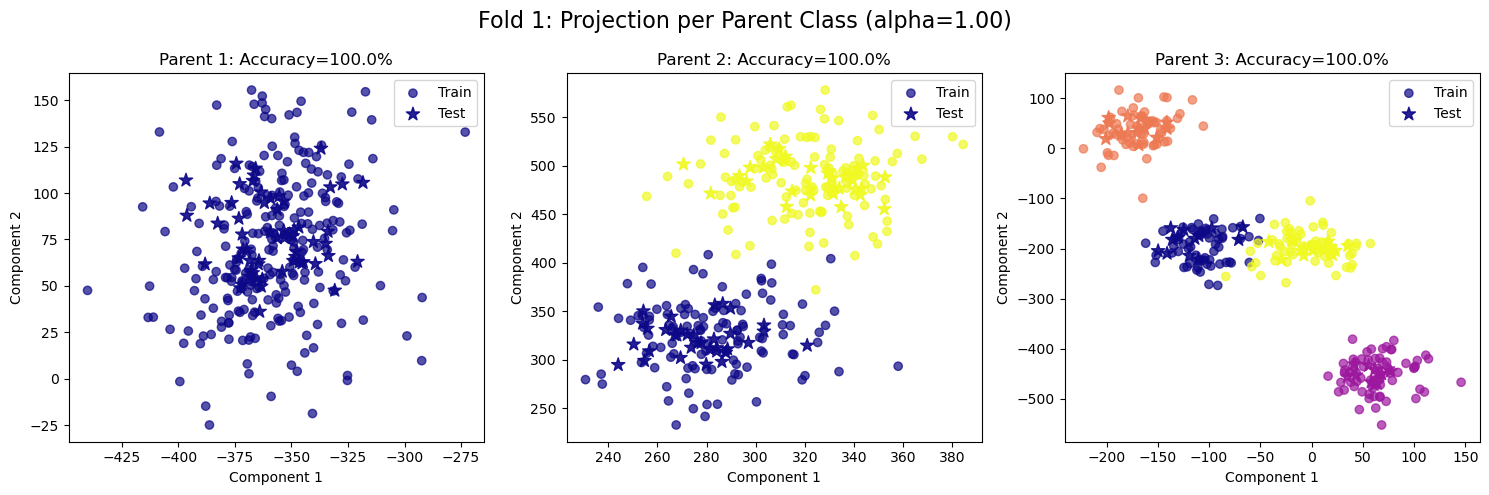

Iter 0: Obj=468.6310, alpha=0.5002, lambda1=0.5000, lambda2=0.5814
Iter 50: Obj=32347.3054, alpha=1.0000, lambda1=0.5002, lambda2=9.5800
Iter 100: Obj=6606.3808, alpha=1.0000, lambda1=0.5008, lambda2=13.9415
Iter 150: Obj=6209.7454, alpha=1.0000, lambda1=0.5012, lambda2=17.2303
Iter 200: Obj=17715.0444, alpha=1.0000, lambda1=0.5017, lambda2=19.7770
Iter 250: Obj=13721.6370, alpha=1.0000, lambda1=0.5020, lambda2=22.5896


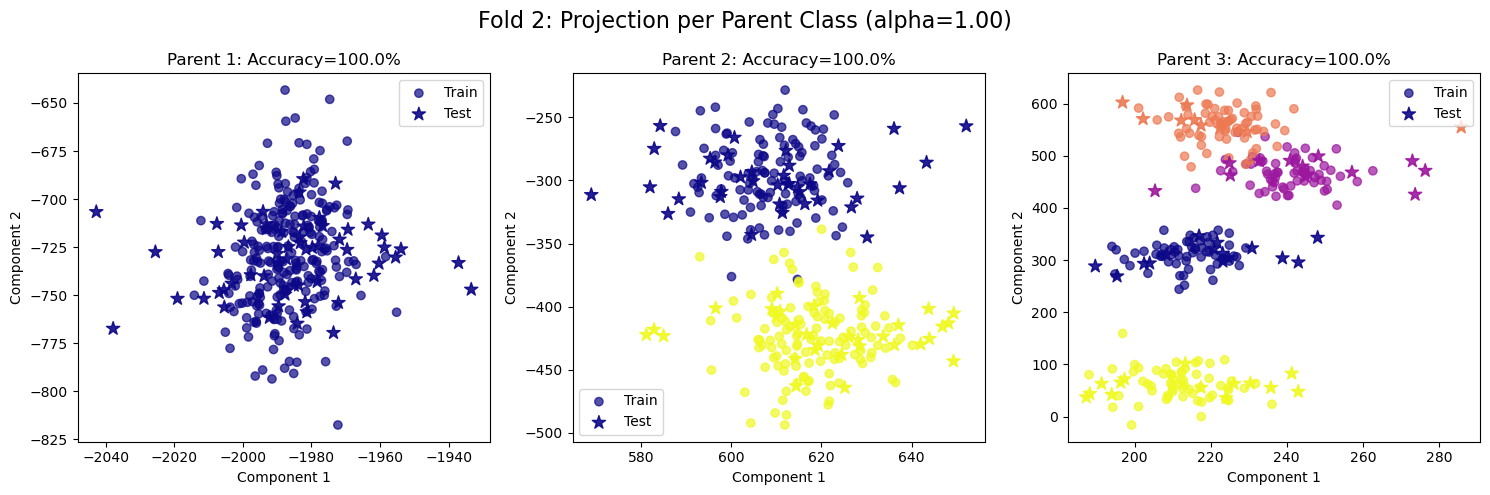

Iter 0: Obj=465.3545, alpha=0.5001, lambda1=0.5000, lambda2=0.5806
Iter 50: Obj=33001.6967, alpha=0.5405, lambda1=0.5002, lambda2=12.2073
Iter 100: Obj=15634.1586, alpha=1.0000, lambda1=0.5003, lambda2=25.3827
Iter 150: Obj=19201.7972, alpha=1.0000, lambda1=0.5007, lambda2=28.0877
Iter 200: Obj=38642.7708, alpha=1.0000, lambda1=0.5010, lambda2=31.0706
Iter 250: Obj=34518.0644, alpha=1.0000, lambda1=0.5013, lambda2=33.8560


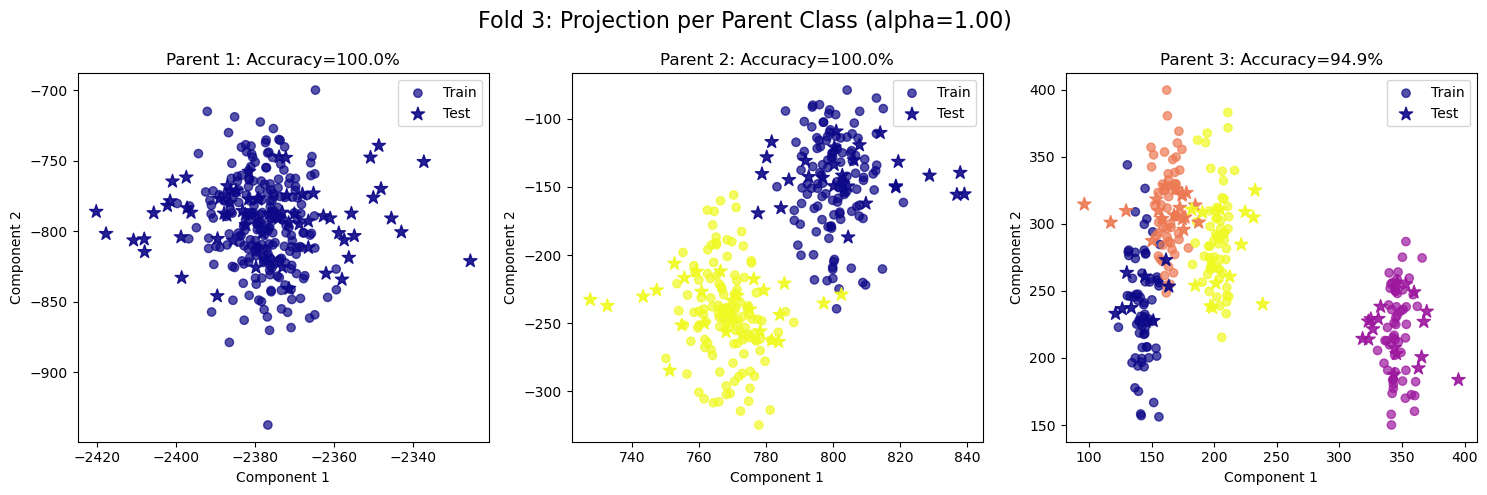

Iter 0: Obj=366.7742, alpha=0.5003, lambda1=0.5000, lambda2=0.5671
Iter 50: Obj=151007.9177, alpha=0.6458, lambda1=0.5002, lambda2=21.5795
Iter 100: Obj=391830.9405, alpha=0.6642, lambda1=0.5002, lambda2=56.4365
Iter 150: Obj=626057.4052, alpha=0.6868, lambda1=0.5003, lambda2=91.0001
Iter 200: Obj=852152.2002, alpha=0.7161, lambda1=0.5003, lambda2=125.2217
Iter 250: Obj=1067474.3151, alpha=0.7578, lambda1=0.5004, lambda2=159.0300


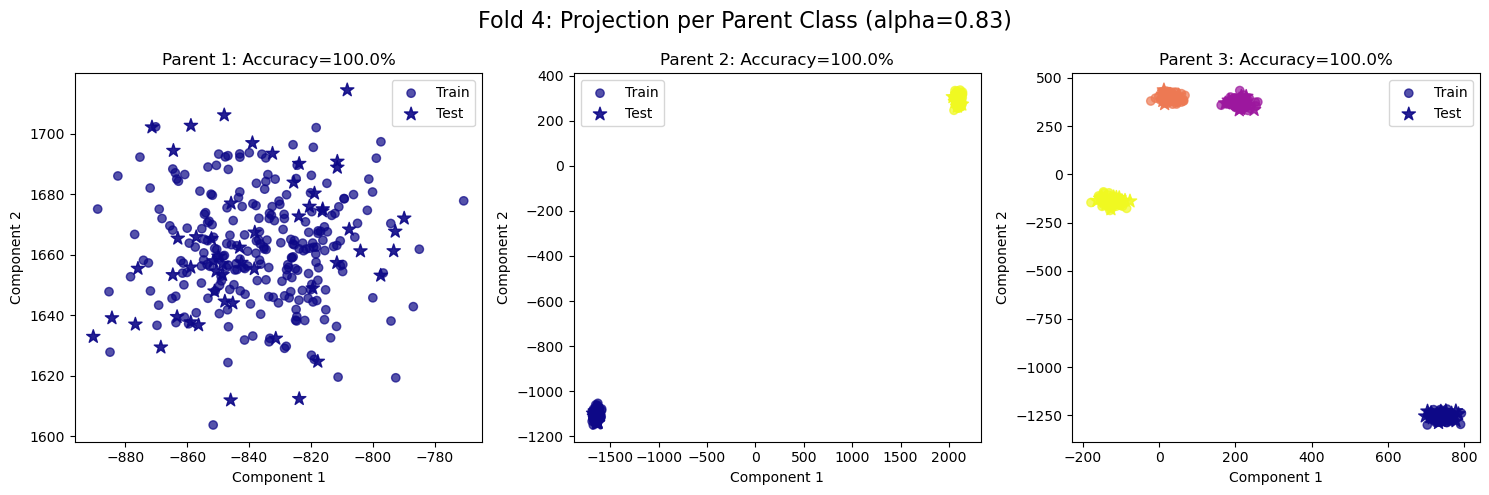

Iter 0: Obj=315.2592, alpha=0.5007, lambda1=0.5000, lambda2=0.5610
Iter 50: Obj=28115.3788, alpha=0.5362, lambda1=0.5004, lambda2=11.6185
Iter 100: Obj=49353.7455, alpha=0.5622, lambda1=0.5006, lambda2=23.1171
Iter 150: Obj=107132.9273, alpha=0.7537, lambda1=0.5009, lambda2=32.8320
Iter 200: Obj=31525.8677, alpha=1.0000, lambda1=0.5011, lambda2=42.7325
Iter 250: Obj=37513.6957, alpha=1.0000, lambda1=0.5014, lambda2=45.8359


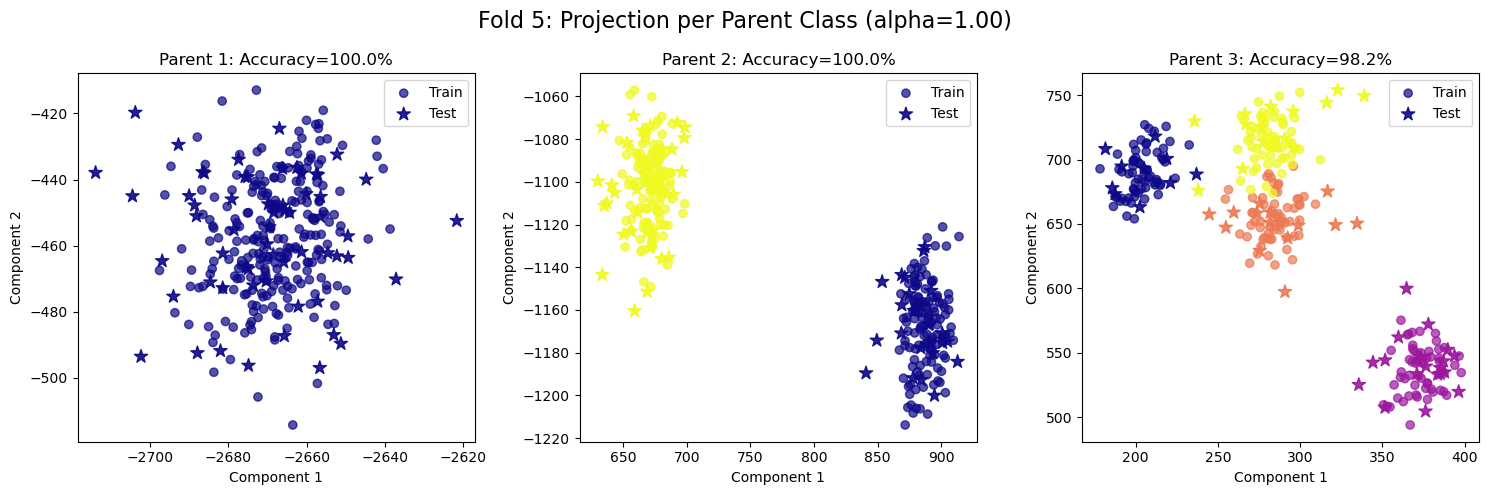

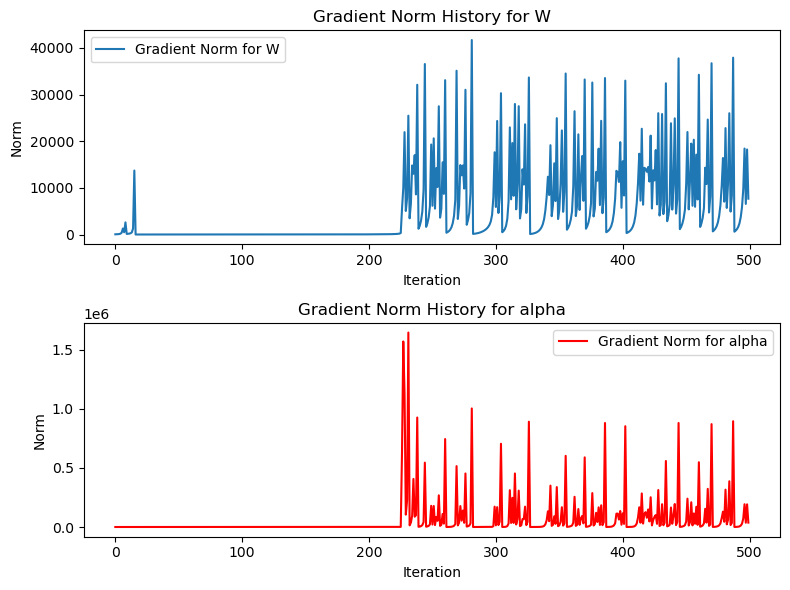

In [290]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from sklearn.model_selection import KFold

# ----------------------
# 1. Data Generation (Hierarchical Data)
# ----------------------
clusters_per_class = {1: [300], 2: [150, 150], 3: [75, 75, 75, 75]}
dims = 1000
class_std = 2
subclass_std = 100
cluster_std = 20
class_means = {
    1: np.pad([100], (0, dims - 1)),
    2: np.pad([0, 100], (0, dims - 2)),
    3: np.pad([0, 0, 100], (0, dims - 3))
}
data_points = []    
labels_class = []    
labels_cluster = []
for class_label, cluster_sizes in clusters_per_class.items():
    base_mean = class_means[class_label]
    for cluster_index, n_points in enumerate(cluster_sizes, start=1):
        subclass_mean = base_mean + np.random.randn(dims) * subclass_std
        points = subclass_mean + np.random.randn(n_points, dims) * cluster_std
        data_points.append(points)
        labels_class.extend([class_label] * n_points)
        labels_cluster.extend([(class_label, cluster_index)] * n_points)
data_points = np.vstack(data_points)
labels_class = np.array(labels_class)
labels_cluster = np.array(labels_cluster)

# ----------------------
# 2. Compute Scatter Matrices
# ----------------------
def compute_scatter_matrices(data, labels_class, labels_cluster, dims):
    overall_mean = np.mean(data, axis=0)
    unique_classes = np.unique(labels_class)
    S_B = np.zeros((dims, dims))
    S_WS = np.zeros((dims, dims))
    S_BS = np.zeros((dims, dims))
    parent_means = {}
    subclass_means = {}
    for c in unique_classes:
        idx = np.where(labels_class == c)[0]
        X_c = data[idx, :]
        N_c = X_c.shape[0]
        mu_c = np.mean(X_c, axis=0)
        parent_means[c] = mu_c
        S_B += N_c * np.outer(mu_c - overall_mean, mu_c - overall_mean)
        class_subs = np.array([lbl[1] for lbl in labels_cluster[idx]])
        unique_subs = np.unique(class_subs)
        subclass_means[c] = []
        for sub in unique_subs:
            idx_sub = np.where(np.array([(lbl[0] == c and lbl[1] == sub) for lbl in labels_cluster]))[0]
            X_cs = data[idx_sub, :]
            N_cs = X_cs.shape[0]
            mu_cs = np.mean(X_cs, axis=0)
            subclass_means[c].append(mu_cs)
            diff = X_cs - mu_cs
            S_WS += diff.T @ diff
            S_BS += N_cs * np.outer(mu_cs - mu_c, mu_cs - mu_c)
    return S_B, S_WS, S_BS, parent_means, subclass_means

S_B_full, S_WS_full, S_BS_full, parent_means_full, subclass_means_full = compute_scatter_matrices(data_points, labels_class, labels_cluster, dims)
reg = 1e-8

# ----------------------
# 3. Hierarchical LDA Objective Function
# ----------------------
def hierarchical_lda_objective(W, S_B, S_W, subclass_means, parent_means, lambda1, lambda2, eps=1e-8):
    numerator = np.trace(W.T @ S_B @ W)
    denominator = np.trace(W.T @ S_W @ W)
    lda_obj = numerator / (denominator + eps)
    R1 = 0.0
    for c, sub_means in subclass_means.items():
        num_sub = len(sub_means)
        for i in range(num_sub):
            for j in range(i+1, num_sub):
                diff = W.T @ (sub_means[i] - sub_means[j])
                norm_val = np.linalg.norm(diff)
                R1 += 1.0 / (norm_val + eps)
    R2 = 0.0
    for c, sub_means in subclass_means.items():
        for mu_cs in sub_means:
            diff = W.T @ (mu_cs - parent_means[c])
            norm_val = np.linalg.norm(diff)
            R2 += norm_val
    return lda_obj + lambda1 * R1 + lambda2 * R2

# ----------------------
# 4. Joint Gradient Ascent on W, lambda1, lambda2, and alpha
# ----------------------
def joint_gradient_ascent(S_B, S_WS, S_BS, subclass_means, parent_means, reg, num_iters=500, step_W=1e-4, step_l1=1e-4, step_l2=1e-4, step_alpha=1e-4, eps=1e-8):
    W = np.random.randn(dims, 2)
    W, _ = np.linalg.qr(W)
    lambda1 = 0.5
    lambda2 = 0.5
    alpha = 0.5
    history = []
    for it in range(num_iters):
        S_W = alpha * S_WS + (1 - alpha) * S_BS + reg * np.eye(dims)
        f = np.trace(W.T @ S_B @ W)
        g = np.trace(W.T @ S_W @ W) + eps
        grad_W = (g * (2 * S_B @ W) - f * (2 * S_W @ W)) / (g**2)
        grad_alpha = - (f / (g**2)) * np.trace(W.T @ (S_WS - S_BS) @ W)
        R1_val = 0.0
        for c, sub_means in subclass_means.items():
            num_sub = len(sub_means)
            for i in range(num_sub):
                for j in range(i+1, num_sub):
                    diff = W.T @ (sub_means[i] - sub_means[j])
                    R1_val += 1.0 / (np.linalg.norm(diff) + eps)
        R2_val = 0.0
        for c, sub_means in subclass_means.items():
            for mu_cs in sub_means:
                diff = W.T @ (mu_cs - parent_means[c])
                R2_val += np.linalg.norm(diff)
        grad_lambda1 = R1_val
        grad_lambda2 = R2_val
        W += step_W * grad_W
        W, _ = np.linalg.qr(W)
        lambda1 += step_l1 * grad_lambda1
        lambda2 += step_l2 * grad_lambda2
        alpha += step_alpha * grad_alpha
        lambda1 = max(lambda1, 0)
        lambda2 = max(lambda2, 0)
        alpha = np.clip(alpha, 0, 1)
        obj = hierarchical_lda_objective(W, S_B, S_W, subclass_means, parent_means, lambda1, lambda2)
        history.append(obj)
        if it % 50 == 0:
            print(f"Iter {it}: Obj={obj:.4f}, alpha={alpha:.4f}, lambda1={lambda1:.4f}, lambda2={lambda2:.4f}")
    return W, lambda1, lambda2, alpha, history

W_opt, best_l1, best_l2, best_alpha, history = joint_gradient_ascent(S_B_full, S_WS_full, S_BS_full, subclass_means_full, parent_means_full, reg, num_iters=500)
print("Best Obj:", history[-1])
print("Best alpha:", best_alpha)
print("Best lambda1:", best_l1)
print("Best lambda2:", best_l2)

# ----------------------
# 5. k-Fold Cross Validation, Classification in Latent Space, and Plot
# ----------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
for train_index, test_index in kf.split(data_points):
    X_train, X_test = data_points[train_index], data_points[test_index]
    y_train = labels_class[train_index]
    y_test = labels_class[test_index]
    cl_train = labels_cluster[train_index]
    cl_test = labels_cluster[test_index]
    S_B_train, S_WS_train, S_BS_train, parent_means_train, subclass_means_train = compute_scatter_matrices(X_train, y_train, cl_train, dims)
    W_fold, l1_fold, l2_fold, alpha_fold, _ = joint_gradient_ascent(S_B_train, S_WS_train, S_BS_train, subclass_means_train, parent_means_train, reg, num_iters=300)
    S_W_train = alpha_fold * S_WS_train + (1 - alpha_fold) * S_BS_train + reg * np.eye(dims)
    X_train_2d = X_train @ W_fold
    X_test_2d = X_test @ W_fold
    # Compute centroids in latent space for each subclass (within a parent)
    centroids = {}  # {parent: {subclass: centroid}}
    for c in np.unique(y_train):
        centroids[c] = {}
        idx = np.where(y_train == c)[0]
        X_c_2d = X_train_2d[idx, :]
        cl_c = cl_train[idx]
        unique_subs = np.unique([lbl[1] for lbl in cl_c])
        for sub in unique_subs:
            idx_sub = np.where(np.array([lbl[1] for lbl in cl_c]) == sub)[0]
            centroids[c][sub] = np.mean(X_c_2d[idx_sub, :], axis=0)
    # Classify test points using nearest centroid (within the same parent)
    pred_sub = []
    for i in range(len(X_test_2d)):
        p = y_test[i]  # parent class
        x = X_test_2d[i, :]
        best_sub = None
        best_dist = np.inf
        for sub, center in centroids[p].items():
            dist = np.linalg.norm(x - center)
            if dist < best_dist:
                best_dist = dist
                best_sub = sub
        pred_sub.append(best_sub)
    pred_sub = np.array(pred_sub)
    true_sub = np.array([lbl[1] for lbl in cl_test])
    # Compute classification accuracy per parent class and overall for test samples
    accs = {}
    for c in np.unique(y_test):
        idx = np.where(y_test == c)[0]
        acc = np.mean(pred_sub[idx] == true_sub[idx])
        accs[c] = acc
    # Plot: For each parent class, we plot the training and test points in latent space colored by subclass,
    # with test points as stars; we annotate the plot with the classification accuracy.
    fig, axs = plt.subplots(1, len(np.unique(y_test)), figsize=(5*len(np.unique(y_test)), 5))
    if len(np.unique(y_test)) == 1:
        axs = [axs]
    for ax, c in zip(axs, np.unique(y_test)):
        idx_train = np.where(y_train == c)[0]
        idx_test = np.where(y_test == c)[0]
        X_c_train = X_train_2d[idx_train, :]
        X_c_test = X_test_2d[idx_test, :]
        subclass_train = np.array([lbl[1] for lbl in cl_train[idx_train]])
        subclass_test = np.array([lbl[1] for lbl in cl_test[idx_test]])
        discrete_cmap_sub = plt.cm.get_cmap('plasma', len(np.unique(subclass_train)))
        sc_tr = ax.scatter(X_c_train[:, 0], X_c_train[:, 1], c=subclass_train, cmap=discrete_cmap_sub, marker='o', alpha=0.7, label='Train')
        sc_te = ax.scatter(X_c_test[:, 0], X_c_test[:, 1], c=subclass_test, cmap=discrete_cmap_sub, marker='*', s=100, alpha=0.9, label='Test')
        ax.set_xlabel("Component 1")
        ax.set_ylabel("Component 2")
        ax.set_title(f"Parent {c}: Accuracy={accs[c]*100:.1f}%")
        ax.legend()
    plt.suptitle(f"Fold {fold}: Projection per Parent Class (alpha={alpha_fold:.2f})", fontsize=16)
    plt.tight_layout()
    plt.show()
    fold += 1

# ----------------------
# 7. Plot Gradient History from Full Data Training
# ----------------------
fig_hist, axs_hist = plt.subplots(2, 1, figsize=(8, 6))
axs_hist[0].plot(gradW_history, label="Gradient Norm for W")
axs_hist[0].set_xlabel("Iteration")
axs_hist[0].set_ylabel("Norm")
axs_hist[0].set_title("Gradient Norm History for W")
axs_hist[0].legend()
axs_hist[1].plot(gradAlpha_history, label="Gradient Norm for alpha", color='red')
axs_hist[1].set_xlabel("Iteration")
axs_hist[1].set_ylabel("Norm")
axs_hist[1].set_title("Gradient Norm History for alpha")
axs_hist[1].legend()
plt.tight_layout()
plt.show()
